Data Loading & Cleaning

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error, mean_squared_error
import seaborn as sns
from itertools import combinations
from sklearn.linear_model import RidgeCV, Ridge, Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy import stats

path = './data/movies_dataset.csv'

df = pd.read_csv(path)

In [2]:
# GENERAL data pre-processing

#We split the dataset intro train and test, and parameters and target
X = df.drop(columns=['Global_BoxOfficeUSD'])
y = df['Global_BoxOfficeUSD']

# Hacer el split ANTES de cualquier transformación
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 20% test
    random_state=42,     # for replicability
    shuffle=True         
)

#We drop the columns that had a high correlation with 'Global_BoxOfficeUSD' as identified during the data cleaning
to_drop_hc = [
    'US_BoxOfficeUSD',       
    'Opening_Day_SalesUSD',  
    'One_Week_SalesUSD'     
]
to_drop_hc = [c for c in to_drop_hc if c in X_train.columns]
if len(to_drop_hc) > 0:
    X_train = X_train.drop(columns=to_drop_hc)
else:
    print("Columns have already been dropped")

#We extract year, month and day from the release date, useful to  detect seasonal patterns
X_train['ReleaseDate'] = pd.to_datetime(X_train['ReleaseDate'], dayfirst=True, errors='coerce')
X_train['ReleaseDate_Year'] = X_train['ReleaseDate'].dt.year
X_train['ReleaseDate_Month'] = X_train['ReleaseDate'].dt.month
X_train['ReleaseDate_Day'] = X_train['ReleaseDate'].dt.day

#Numerical column scaling
cols_to_scale = [
    'BudgetUSD', 
    'NumVotesIMDb', 'NumVotesRT',
    'IMDbRating', 'RottenTomatoesScore',
    'ReleaseDate_Year', 'ReleaseDate_Month', 'ReleaseDate_Day'
]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

#We also drop some non-numerical columns that are not relevant for specific models
to_drop_n = [
    'MovieID',       
    'Title',  
    'Director',
    'LeadActor',
    'ReleaseYear', #numerical but duplicated, as we will convert ReleaseDate to separate year, month and day columns
    'ReleaseDate'  #already used, to get the year, month and day columns
]
to_drop_n = [c for c in to_drop_n if c in X_train_scaled.columns]
if len(to_drop_n) > 0:
    X_train_numerical = X_train_scaled.drop(columns=to_drop_n)
else:
    print("Columns have already been dropped")

#There are not too many different genres/countries, so they can be useful if we one-hot encode them
X_train_numerical = pd.get_dummies(X_train_numerical, columns=['Genre'], prefix='Genre')
X_train_numerical = pd.get_dummies(X_train_numerical, columns=['Country'], prefix='Country')

#We apply the same transformations to the test set

# Drop same correlated columns
X_test = X_test.drop(columns=to_drop_hc, errors='ignore')

# ReleaseDate → year / month / day
X_test['ReleaseDate'] = pd.to_datetime(X_test['ReleaseDate'], dayfirst=True, errors='coerce')
X_test['ReleaseDate_Year'] = X_test['ReleaseDate'].dt.year
X_test['ReleaseDate_Month'] = X_test['ReleaseDate'].dt.month
X_test['ReleaseDate_Day'] = X_test['ReleaseDate'].dt.day

# Scaling (use transform only!)
X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Drop the same non-numerical columns
X_test_numerical = X_test_scaled.drop(columns=to_drop_n, errors='ignore')

# One-hot encoding: ensure same columns as train
X_test_numerical = pd.get_dummies(X_test_numerical, columns=['Genre'], prefix='Genre')
X_test_numerical = pd.get_dummies(X_test_numerical, columns=['Country'], prefix='Country')

# Reindex to match train columns
X_test_numerical = X_test_numerical.reindex(columns=X_train_numerical.columns, fill_value=0)

print("Final dataset shape:", X_train_numerical.shape)
X_train_numerical.head()

Final dataset shape: (799999, 26)


BudgetUSD  IMDbRating  RottenTomatoesScore  NumVotesIMDb  NumVotesRT  \
566853  -0.241545    0.675644             1.148362     -0.190588    0.638026   
382311  -0.047463   -0.939364            -1.068053     -0.353971   -0.200939   
241519  -0.306311   -1.141241            -0.840729     -0.276840   -0.234123   
930120  -0.347633    0.810228             0.239064     -0.321399   -0.233175   
911069  -0.421552    0.271892            -0.272417     -0.348078   -0.197384   

        ReleaseDate_Year  ReleaseDate_Month  ReleaseDate_Day  Genre_Action  \
566853         -0.312189           1.299563        -0.651791         False   
382311         -0.571845          -1.312673        -0.651791         False   
241519          0.674506          -0.151679        -0.197554         False   
930120          0.622574          -0.151679         0.483803         False   
911069          0.310987          -1.602922         0.710922          True   

        Genre_Comedy  ...  Country_Australia  Country_Canada  Country_China  \
566853          True  ...              False           False          False   
382311         False  ...               True           False          False   
241519         False  ...              False           False          False   
930120         False  ...              False           False          False   
911069         False  ...              False           False          False   

        Country_France  Country_Germany  Country_India  Country_Japan  \
566853           False             True          False          False   
382311           False            False          False          False   
241519           False            False          False          False   
930120           False            False          False          False   
911069           False            False          False          False   

        Country_South Korea  Country_UK  Country_USA  
566853                False       False        False  
382311                False       False        False  
241519                False       False         True  
930120                False       False         True  
911069                False       False         True  

[5 rows x 26 columns]

In [3]:
# Sampling of the dataset to optimize heavy models
# Stratifying in quartiles by revenue
y_train_quartiles = pd.qcut(y_train, q=4, labels=False, duplicates='drop')

# Create a subset of 15% of the data
X_subset, _, y_subset, _ = train_test_split(
    X_train_numerical,  
    y_train,
    train_size=0.15,
    stratify=y_train_quartiles,
    random_state=123
)

print(f"\nDatasets for optimization:")
print(f"   Train (whole): {X_train_numerical.shape[0]:,} samples")
print(f"   Subset (15%):   {X_subset.shape[0]:,} samples")
print(f"   Test:           {X_test_numerical.shape[0]:,} samples")

# Verificar representatividad
print(f"\nVerification:")
print(f"   Train - Mean: ${y_train.mean()/1e6:.1f}M, Std: ${y_train.std()/1e6:.1f}M")
print(f"   Subset - Mean: ${y_subset.mean()/1e6:.1f}M, Std: ${y_subset.std()/1e6:.1f}M")


Datasets for optimization:
   Train (whole): 799,999 samples
   Subset (15%):   119,999 samples
   Test:           200,000 samples

Verification:
   Train - Mean: $27.1M, Std: $69.3M
   Subset - Mean: $27.3M, Std: $69.8M


In [4]:
# Single variable data preprocessing

# --- 1. DATA PREPARATION ---
# Define the Target Variable
target = 'Global_BoxOfficeUSD'

# Define X (Predictor) and y (Target)
# For Simple Regression, X must be a DataFrame with a single column (double brackets)
X_simple = df[['BudgetUSD']] 
y = df[target]

print(f"Predictor Variable (X): BudgetUSD")
print(f"Target Variable (y): {target}")

# --- 2. TRAIN / TEST SPLIT ---
# Split 80% for training and 20% for testing
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X_simple, 
    y, 
    test_size=0.2, 
    random_state=42
)

# --- 3. SCALING (StandardScaler) ---
# Even for simple regression, it is good practice to scale money values
scaler = StandardScaler()

# Fit only on training data to avoid data leakage ("peeking" at the test set)
X_train_scaled_simple = scaler.fit_transform(X_train_simple)
X_test_scaled_simple = scaler.transform(X_test_simple)

Predictor Variable (X): BudgetUSD
Target Variable (y): Global_BoxOfficeUSD


SIMPLE LINEAR REGRESSION (We will predict the Global_BoxOfficeUSD based on the BudgetUSD)


=== SIMPLE LINEAR REGRESSION RESULTS ===
R2 Score (Accuracy): 0.8039
RMSE (Root Mean Squared Error): $31,298,516.55
MAE (Mean Absolute Error):      $10,837,028.44


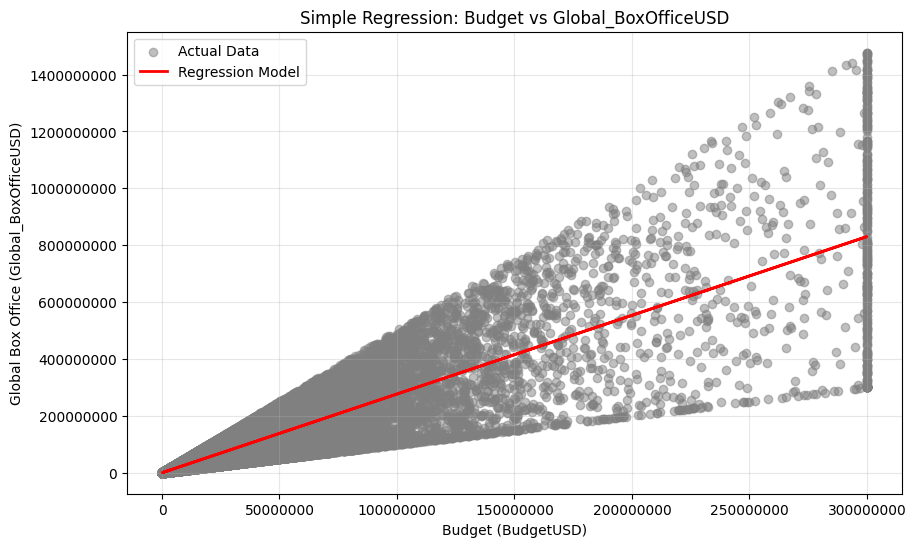


=== EVALUATION REPORT: SIMPLE REGRESSION ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


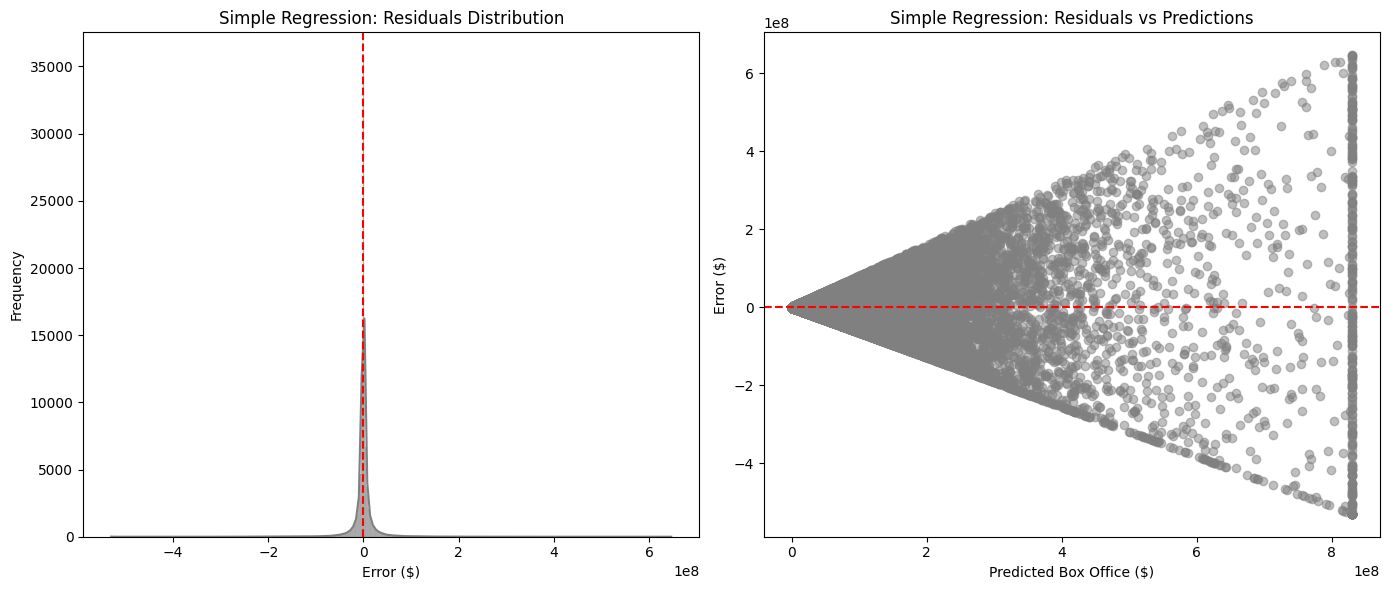

In [5]:
# --- 4. MODEL TRAINING (OLS) ---
simple_model = LinearRegression()
simple_model.fit(X_train_scaled_simple, y_train_simple)

# --- 5. PREDICTION AND EVALUATION ---
y_pred_simple = simple_model.predict(X_test_scaled_simple)

# Calculate metrics
r2 = r2_score(y_test_simple, y_pred_simple)
rmse = np.sqrt(mean_squared_error(y_test_simple, y_pred_simple))
mae = mean_absolute_error(y_test_simple, y_pred_simple)

print("\n=== SIMPLE LINEAR REGRESSION RESULTS ===")
print(f"R2 Score (Accuracy): {r2:.4f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:,.2f}")
print(f"MAE (Mean Absolute Error):      ${mae:,.2f}")

# --- 6. VISUALIZATION ---
plt.figure(figsize=(10, 6))

# Pro Tip: Inverse transform the X-axis to show real Dollars, not standard deviations
X_test_real_dollars = scaler.inverse_transform(X_test_scaled_simple)

# Real data points (Scatter)
plt.scatter(X_test_real_dollars, y_test_simple, color='gray', alpha=0.5, label='Actual Data')

# Prediction line
plt.plot(X_test_real_dollars, y_pred_simple, color='red', linewidth=2, label='Regression Model')

plt.title(f'Simple Regression: Budget vs {target}')
plt.xlabel('Budget (BudgetUSD)')
plt.ylabel('Global Box Office (Global_BoxOfficeUSD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format axes to avoid scientific notation (e.g., 1e9)
plt.ticklabel_format(style='plain', axis='both') 
plt.show()

#EVALUATION

# --- 7. MODEL EVALUATION (Overfitting & Residuals) ---
# We use the 'simple_model' you just trained

print("\n=== EVALUATION REPORT: SIMPLE REGRESSION ===")

# 1. OVERFITTING CHECK
# Predict on both Train and Test sets to compare performance
y_train_pred_simple = simple_model.predict(X_train_scaled_simple)

# Calculate R2 Scores
r2_train = r2_score(y_train_simple, y_train_pred_simple)
r2_test = r2_score(y_test_simple, y_pred_simple)

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

# Check the difference
diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
    print("The model explains the training data much better than the test data.")
elif diff < -0.05:
    print(f" Suspicious: Test score is better than Train score.")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
# Calculate errors (Real - Predicted)
residuals = y_test_simple - y_pred_simple

plt.figure(figsize=(14, 6))

# Plot A: Residuals Distribution (Histogram)
# We want a bell curve centered at 0 (Normal Distribution)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='gray')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Simple Regression: Residuals Distribution')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

# Plot B: Residuals vs. Predicted (Homoscedasticity)
# We want a random cloud of points. No funnel shapes.
plt.subplot(1, 2, 2)
plt.scatter(y_pred_simple, residuals, alpha=0.5, color='gray')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Simple Regression: Residuals vs Predictions')
plt.xlabel('Predicted Box Office ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

MULTIPLE LINEAR REGRESSION(We will predict the Global_BoxOfficeUSD based on multiple variables, we will try different algorithms)

In [6]:
print(f"Training Features Shape: {X_train_numerical.shape}")
print(f"Testing Features Shape:  {X_test_numerical.shape}")
print(f"Total Predictors (Columns): {X_train_numerical.shape[1]}")

Training Features Shape: (799999, 26)
Testing Features Shape:  (200000, 26)
Total Predictors (Columns): 26


ORDINARY LEAST SQUARES(OLS)

--- 1. ORDINARY LEAST SQUARES (OLS) ---
R2 Score: 0.8039
RMSE:     $31,298,743.60


C:\Users\jon.palacios\AppData\Local\Temp\ipykernel_30060\1300605401.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


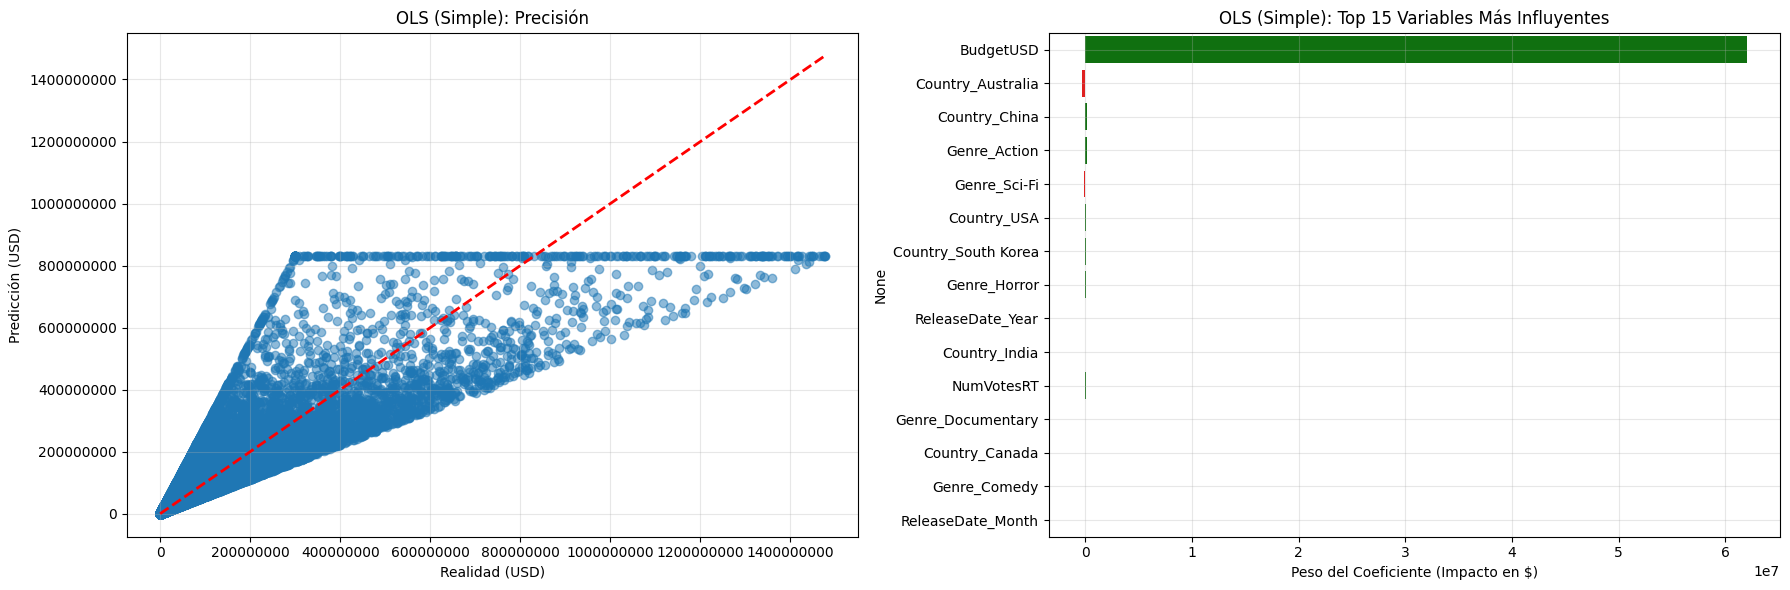


=== EVALUATION REPORT: OLS (Simple) ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


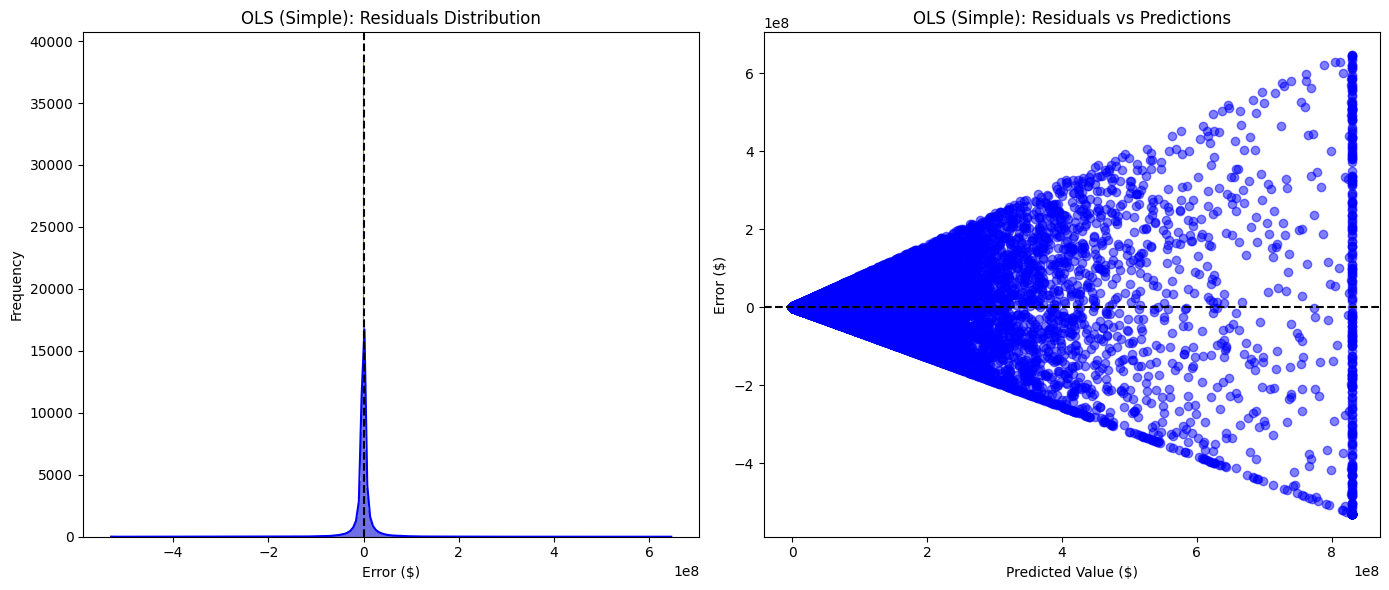


=== PERFORMANCE METRICS ===
R² Score:       0.803929
Adjusted R²:    0.803904
RMSE:           $31,298,743.60
MAE:            $10,839,986.42
MAPE:           57.59%
MedianAPE:           57.59%
MSLE: 0.336650

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$61,993,870.54
  • Country_China: +$179,747.48
  • Genre_Action: +$140,137.46
  • Country_USA: +$81,557.31
  • Country_South Korea: +$76,086.69

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • Country_Australia: $-304,638.50
  • Genre_Sci-Fi: $-130,162.75
  • ReleaseDate_Year: $-62,247.59
  • Country_India: $-52,420.27
  • Genre_Documentary: $-35,004.31

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [20]:
print("--- 1. ORDINARY LEAST SQUARES (OLS) ---")

# A. Initialize the model
ols_model = LinearRegression()

# B. Train the model using the processed training data
ols_model.fit(X_train_numerical, y_train) 

# C. Make predictions on the test set
y_pred_ols = ols_model.predict(X_test_numerical) 

# D. Evaluate metrics
r2_ols = r2_score(y_test, y_pred_ols)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))

print(f"R2 Score: {r2_ols:.4f}")
print(f"RMSE:     ${rmse_ols:,.2f}")

#VISUALIZATION
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

model = ols_model
name = "OLS (Simple)"
y_pred = model.predict(X_test_numerical) 

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns)
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables Más Influyentes')
plt.xlabel('Peso del Coeficiente (Impacto en $)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION

# --- EVALUATION: OLS (Ordinary Least Squares) ---
model_name = "OLS (Simple)"
current_model = ols_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
# Predict on Train set
y_train_pred = current_model.predict(X_train_numerical) 

# Calculate R2 Scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_ols)

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

# Check the difference
diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
elif diff < -0.05:
    print(f" Suspicious: Test score is better than Train score.")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_ols 

plt.figure(figsize=(14, 6))

# Plot A: Residuals Distribution (Histogram)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='blue')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

# Plot B: Residuals vs. Predicted (Homoscedasticity)
plt.subplot(1, 2, 2)
plt.scatter(y_pred_ols, residuals, alpha=0.5, color='blue') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_ols = mean_absolute_error(y_test, y_pred_ols)
mape_ols = np.mean(np.abs((y_test - y_pred_ols) / y_test)) * 100
median_ape_ols = np.median(np.abs((y_test - y_pred_ols) / y_test)) * 100
y_pred_positive = np.maximum(y_pred, 1) #we correct negative values that make msle not work
msle = mean_squared_log_error(y_test, y_pred_positive)


# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_ols = 1 - (1 - r2_ols) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_ols:.6f}")
print(f"Adjusted R²:    {adj_r2_ols:.6f}")
print(f"RMSE:           ${rmse_ols:,.2f}")
print(f"MAE:            ${mae_ols:,.2f}")
print(f"MAPE:           {mape_ols:.2f}%")
print(f"MedianAPE:           {mape_ols:.2f}%")
print(f"MSLE: {msle:.6f}")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(ols_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

RIDGE REGRESSION(L2 REGULARIZATION)


--- 2. RIDGE REGRESSION (L2) ---
R2 Score:   0.8039
RMSE:       $31,298,796.94
Best Alpha: 100.0


C:\Users\asier.vinos\AppData\Local\Temp\ipykernel_22232\647418970.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


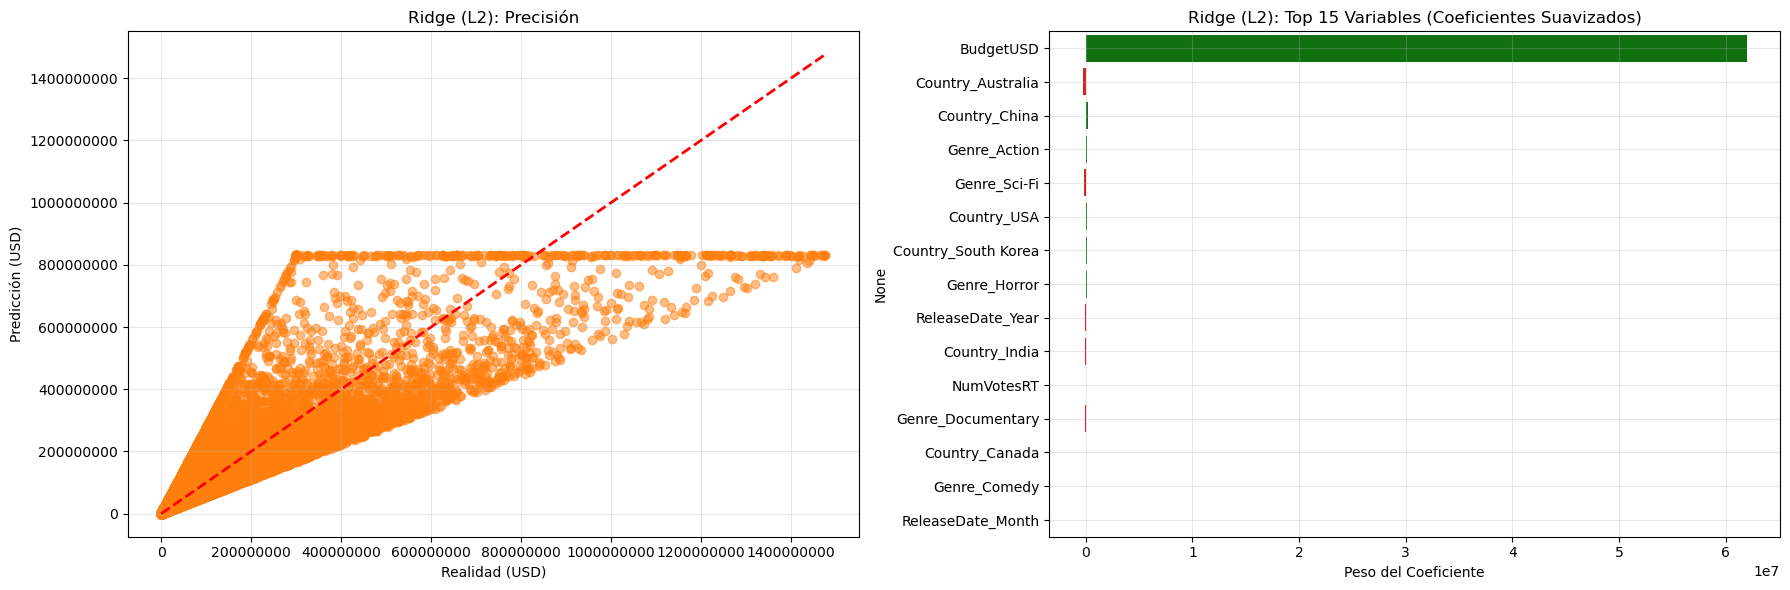


=== EVALUATION REPORT: Ridge (L2) ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


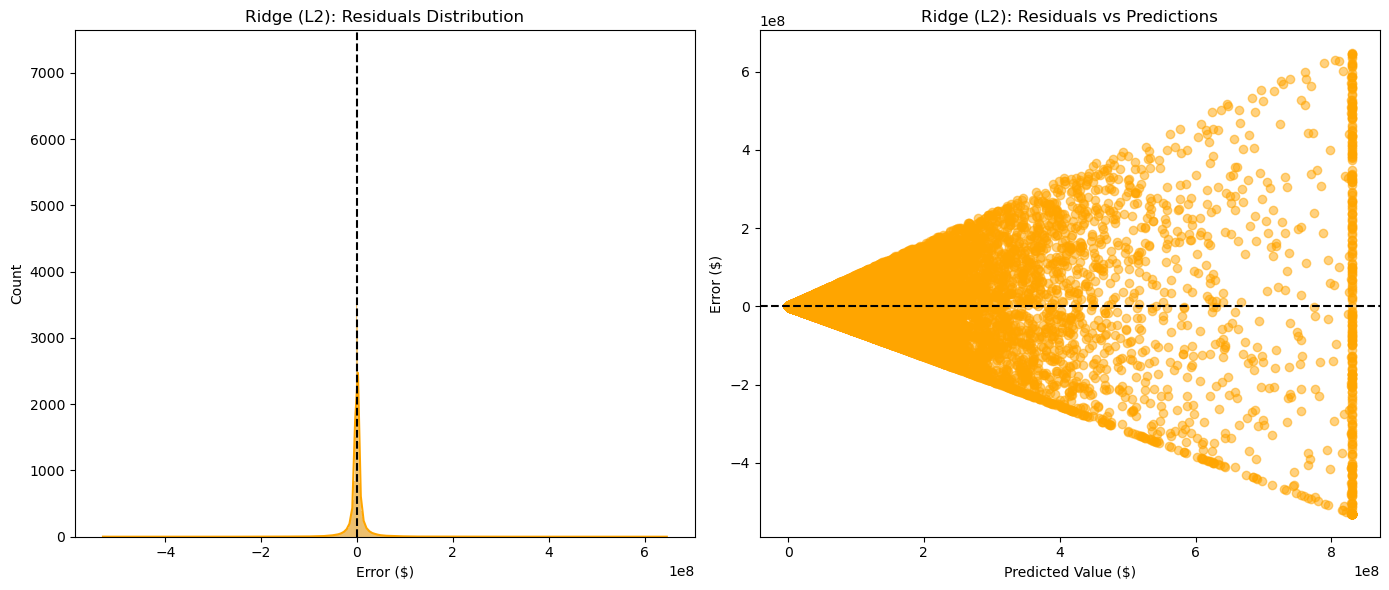


=== PERFORMANCE METRICS ===
R² Score:       0.8039
Adjusted R²:    0.8039
RMSE:           $31,298,796.94
MAE:            $10,840,051.29
MAPE:           57.65%

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$61,986,121.44
  • Country_China: +$179,031.12
  • Genre_Action: +$139,907.63
  • Country_USA: +$81,551.59
  • Country_South Korea: +$75,183.96

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • Country_Australia: $-303,344.46
  • Genre_Sci-Fi: $-129,858.66
  • ReleaseDate_Year: $-62,236.19
  • Country_India: $-52,244.30
  • Genre_Documentary: $-34,869.02

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [15]:
print("\n--- 2. RIDGE REGRESSION (L2) ---")

# A. Initialize Ridge with Cross-Validation (CV)
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0, 50.0, 100.0])

# B. Train
ridge_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_ridge = ridge_model.predict(X_test_numerical) 

# D. Evaluate
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"R2 Score:   {r2_ridge:.4f}")
print(f"RMSE:       ${rmse_ridge:,.2f}")
print(f"Best Alpha: {ridge_model.alpha_}")

#VISUALIZATION
model = ridge_model
name = "Ridge (L2)"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.5, color='tab:orange') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables (Coeficientes Suavizados)')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION
# --- EVALUATION: RIDGE REGRESSION ---
model_name = "Ridge (L2)"
current_model = ridge_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_ridge)

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_ridge 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='orange')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_ridge, residuals, alpha=0.5, color='orange') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mape_ridge = np.mean(np.abs((y_test - y_pred_ridge) / y_test)) * 100

# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_ridge = 1 - (1 - r2_ridge) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_ridge:.4f}")
print(f"Adjusted R²:    {adj_r2_ridge:.4f}")
print(f"RMSE:           ${rmse_ridge:,.2f}")
print(f"MAE:            ${mae_ridge:,.2f}")
print(f"MAPE:           {mape_ridge:.2f}%")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(ridge_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

LASSO REGRESSION


--- 3. LASSO REGRESSION ---
R2 Score:   0.8039
RMSE:       $31,299,010.06
Features eliminated: 24 out of 26


C:\Users\asier.vinos\AppData\Local\Temp\ipykernel_7196\2610985410.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


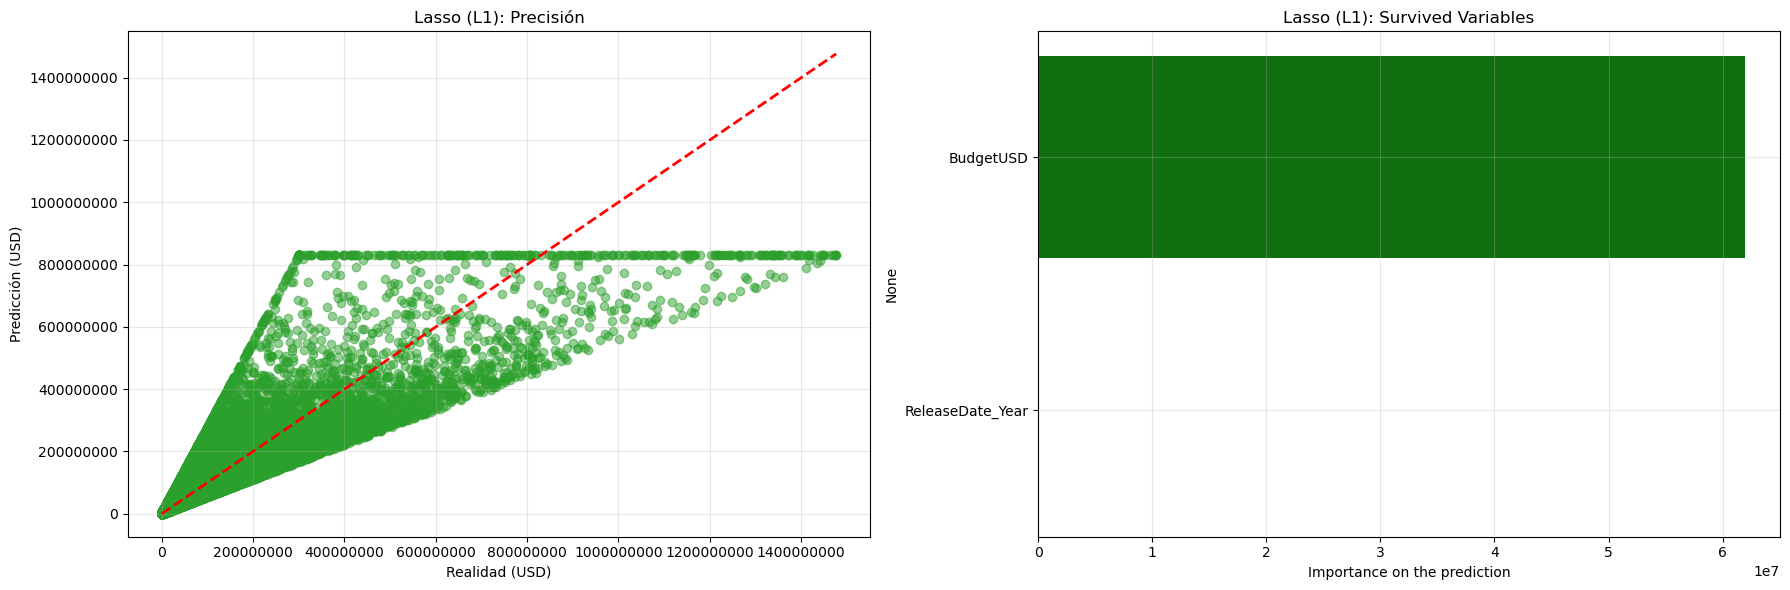

Lasso eliminó 24 variables irrelevantes.

=== EVALUATION REPORT: Lasso (L1) ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


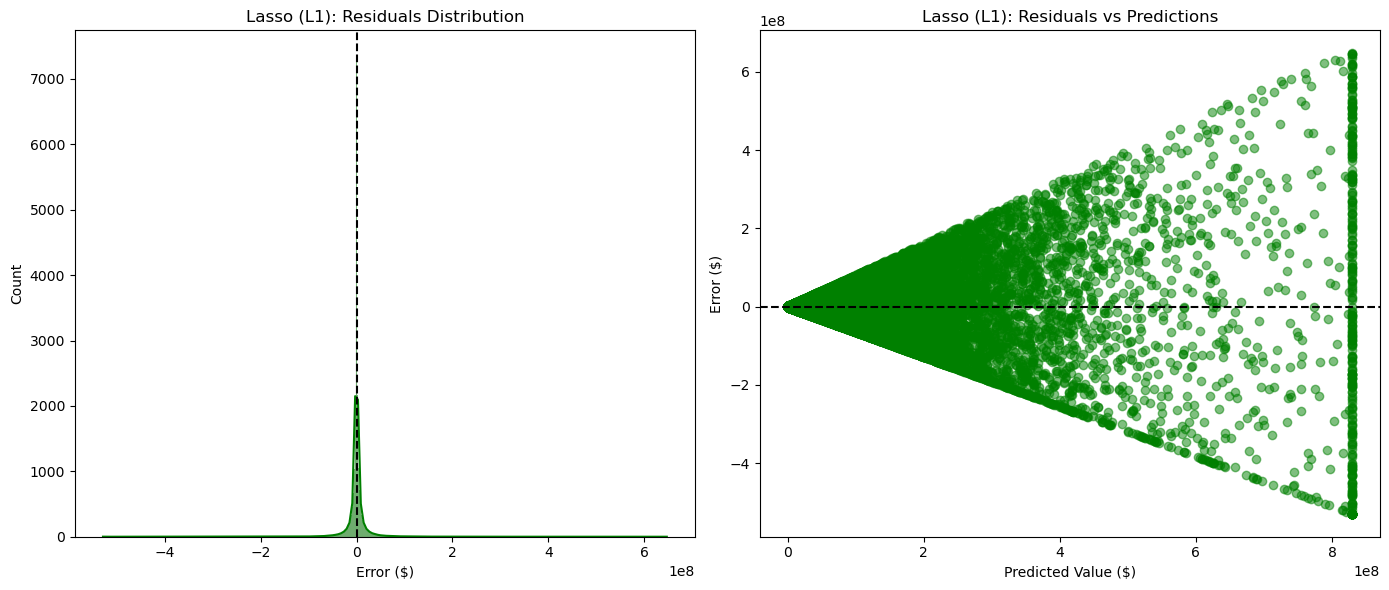


=== PERFORMANCE METRICS ===
R² Score:       0.8039
Adjusted R²:    0.8039
RMSE:           $31,299,010.06
MAE:            $10,837,739.67
MAPE:           57.73%

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$61,931,535.22
  • IMDbRating: +$0.00
  • RottenTomatoesScore: +$0.00
  • NumVotesIMDb: +$0.00
  • NumVotesRT: +$0.00

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • ReleaseDate_Year: $-187.31
  • IMDbRating: $0.00
  • RottenTomatoesScore: $0.00
  • NumVotesIMDb: $0.00
  • NumVotesRT: $0.00

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [6]:
print("\n--- 3. LASSO REGRESSION ---")

# A. Initialize Lasso with CV
lasso_model = LassoCV(cv=5, random_state=42, max_iter=10000)

# B. Train
lasso_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_lasso = lasso_model.predict(X_test_numerical) 

# D. Evaluate
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# Count how many features were ignored (coefficient became 0)
params_zero = np.sum(lasso_model.coef_ == 0)
total_params = len(lasso_model.coef_)

print(f"R2 Score:   {r2_lasso:.4f}")
print(f"RMSE:       ${rmse_lasso:,.2f}")
print(f"Features eliminated: {params_zero} out of {total_params}")

#VISUALIZATION
model = lasso_model
name = "Lasso (L1)"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lasso, alpha=0.5, color='tab:green') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
coefs_active = coefs[coefs != 0]
top_coefs = coefs_active.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs_active[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Survived Variables')
plt.xlabel('Importance on the prediction')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Lasso eliminó {len(coefs) - len(coefs_active)} variables irrelevantes.")

#EVALUATION
# --- EVALUATION: LASSO REGRESSION ---
model_name = "Lasso (L1)"
current_model = lasso_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical) 

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_lasso) 

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_lasso 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='green')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_lasso, residuals, alpha=0.5, color='green') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mape_lasso = np.mean(np.abs((y_test - y_pred_lasso) / y_test)) * 100

# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_lasso = 1 - (1 - r2_lasso) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_lasso:.4f}")
print(f"Adjusted R²:    {adj_r2_lasso:.4f}")
print(f"RMSE:           ${rmse_lasso:,.2f}")
print(f"MAE:            ${mae_lasso:,.2f}")
print(f"MAPE:           {mape_lasso:.2f}%")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(lasso_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

ELASTIC NET REGRESSION


--- 4. ELASTIC NET ---
R2 Score:      0.8039
RMSE:          $31,298,815.61
Best L1 Ratio: 0.99


C:\Users\asier.vinos\AppData\Local\Temp\ipykernel_7196\3839307873.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


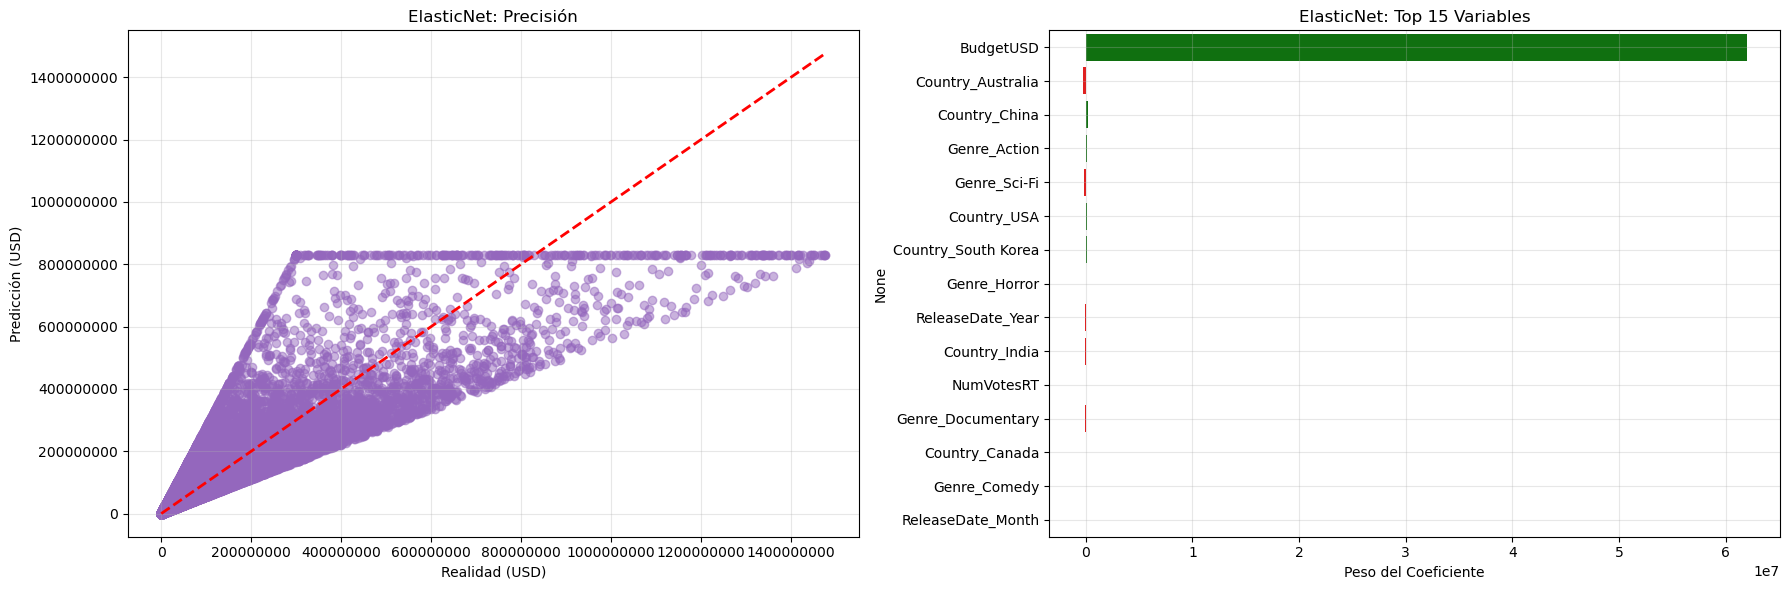


=== EVALUATION REPORT: ElasticNet ===
R2 Score (Train): 0.8013
R2 Score (Test):  0.8039
 STATUS: Healthy model (Good generalization).


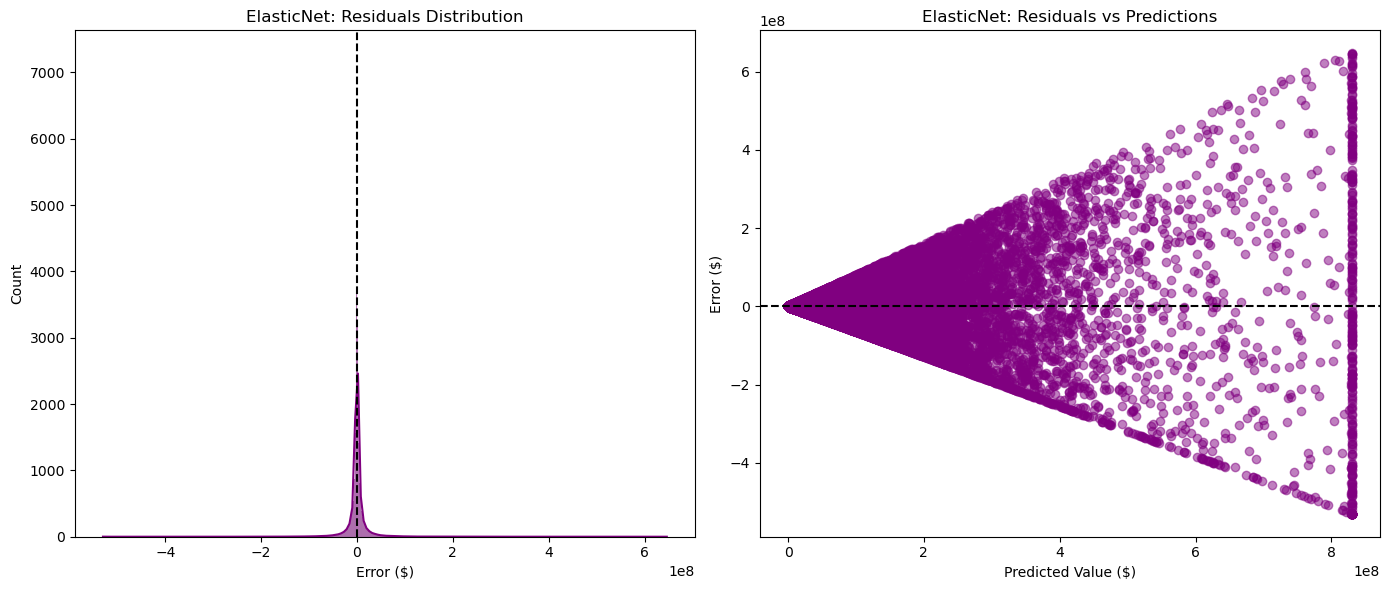


=== PERFORMANCE METRICS ===
R² Score:       0.8039
Adjusted R²:    0.8039
RMSE:           $31,298,815.61
MAE:            $10,840,074.24
MAPE:           57.67%

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$61,983,475.82
  • Country_China: +$178,786.94
  • Genre_Action: +$139,855.18
  • Country_USA: +$81,549.27
  • Country_South Korea: +$74,878.74

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • Country_Australia: $-302,904.80
  • Genre_Sci-Fi: $-129,728.86
  • ReleaseDate_Year: $-62,232.27
  • Country_India: $-52,184.43
  • Genre_Documentary: $-34,796.66

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [7]:
print("\n--- 4. ELASTIC NET ---")

# A. Initialize ElasticNet with CV
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99], alphas=np.logspace(-3, 1, 50), cv=5, random_state=42, max_iter=10000)

# B. Train
elastic_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_elastic = elastic_model.predict(X_test_numerical) 

# D. Evaluate
r2_elastic = r2_score(y_test, y_pred_elastic)
rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

print(f"R2 Score:      {r2_elastic:.4f}")
print(f"RMSE:          ${rmse_elastic:,.2f}")
print(f"Best L1 Ratio: {elastic_model.l1_ratio_}")

#VISUALIZATION
model = elastic_model
name = "ElasticNet"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_elastic, alpha=0.5, color='tab:purple') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION
# --- EVALUATION: ELASTIC NET ---
model_name = "ElasticNet"
current_model = elastic_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical)  

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_elastic) 

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_elastic 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_elastic, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)
mape_elastic = np.mean(np.abs((y_test - y_pred_elastic) / y_test)) * 100

# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_elastic = 1 - (1 - r2_elastic) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_elastic:.4f}")
print(f"Adjusted R²:    {adj_r2_elastic:.4f}")
print(f"RMSE:           ${rmse_elastic:,.2f}")
print(f"MAE:            ${mae_elastic:,.2f}")
print(f"MAPE:           {mape_elastic:.2f}%")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(elastic_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

STOCHASTIC GRADIENT DESCENT(SGD)


--- 5. SGD REGRESSOR ---
R2 Score: 0.8036
RMSE:     $31,323,878.57


C:\Users\asier.vinos\AppData\Local\Temp\ipykernel_22232\2262417763.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)


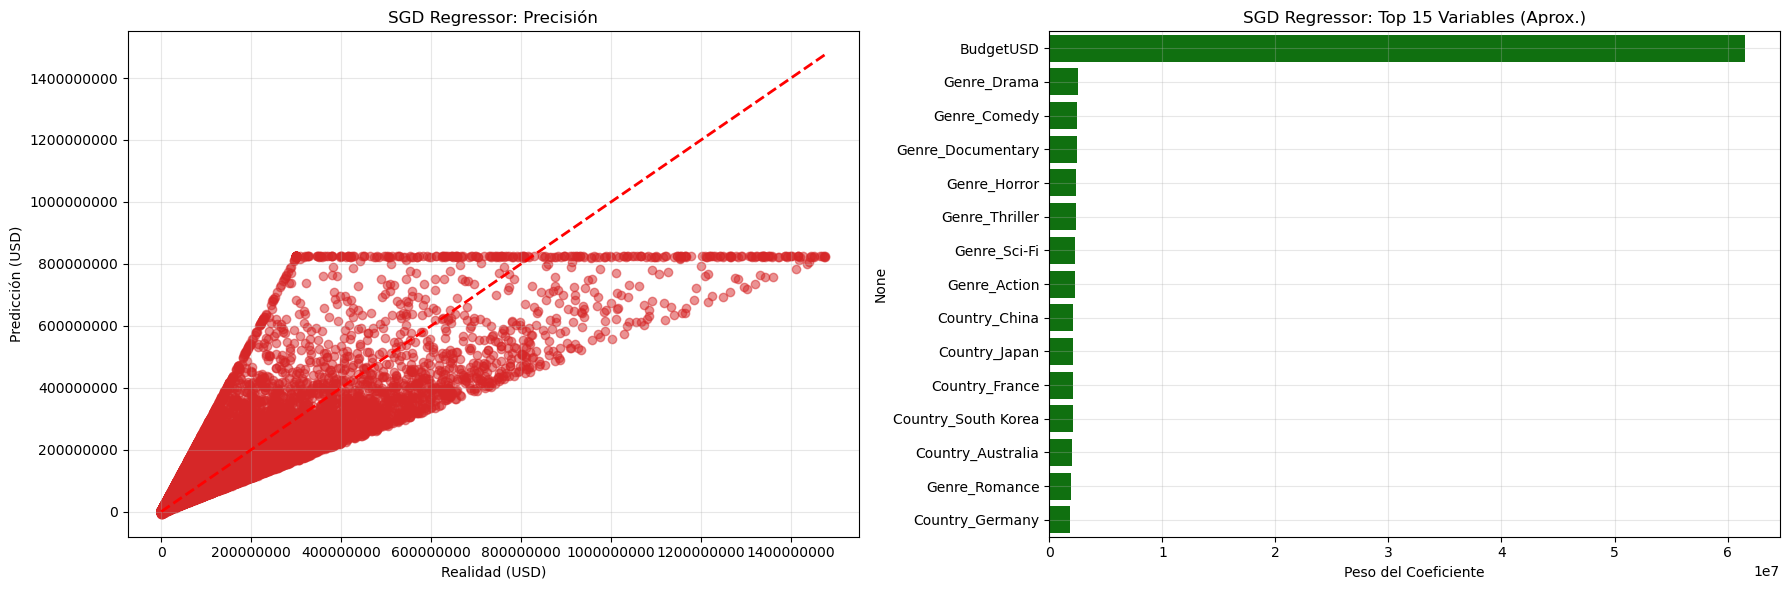


=== EVALUATION REPORT: SGD Regressor ===
R2 Score (Train): 0.8010
R2 Score (Test):  0.8036
 STATUS: Healthy model (Good generalization).


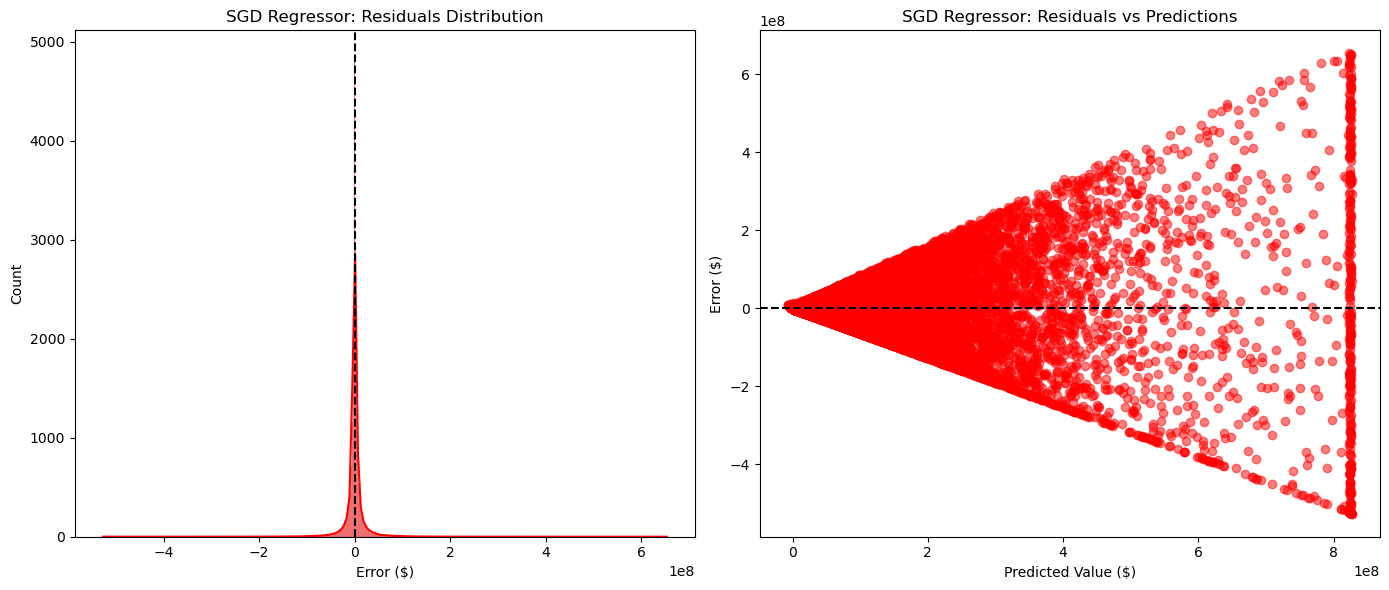


=== PERFORMANCE METRICS ===
R² Score:       0.8036
Adjusted R²:    0.8039
RMSE:           $31,323,878.57
MAE:            $10,991,272.66
MAPE:           73.29%

=== COEFFICIENT INTERPRETATION ===

TOP 5 POSITIVE IMPACT (Increase Box Office):
  • BudgetUSD: +$61,561,289.91
  • Genre_Drama: +$2,566,320.51
  • Genre_Comedy: +$2,481,244.92
  • Genre_Documentary: +$2,413,658.78
  • Genre_Horror: +$2,390,444.25

TOP 5 NEGATIVE IMPACT (Decrease Box Office):
  • ReleaseDate_Day: $-712,600.46
  • IMDbRating: $-191,423.18
  • NumVotesIMDb: $-180,668.32
  • NumVotesRT: $-107,530.55
  • ReleaseDate_Year: $255,930.86

NOTE: Coefficients show the change in Box Office (in $) for a
1-unit increase in the feature (after scaling).


In [ ]:
print("\n--- 5. SGD REGRESSOR ---")

# A. Initialize SGD
sgd_model = SGDRegressor(
    max_iter=1000, 
    tol=1e-3, 
    penalty='elasticnet', 
    random_state=42
)

# B. Train
sgd_model.fit(X_train_numerical, y_train) 

# C. Predict
y_pred_sgd = sgd_model.predict(X_test_numerical)  

# D. Evaluate
r2_sgd = r2_score(y_test, y_pred_sgd)
rmse_sgd = np.sqrt(mean_squared_error(y_test, y_pred_sgd))

print(f"R2 Score: {r2_sgd:.4f}")
print(f"RMSE:     ${rmse_sgd:,.2f}")

#VISUALIZATION
model = sgd_model
name = "SGD Regressor"

plt.figure(figsize=(18, 6))

# Graph1: Reality vs Prediction
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_sgd, alpha=0.5, color='tab:red') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Realidad (USD)')
plt.ylabel('Predicción (USD)')
plt.title(f'{name}: Precisión')
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')

# Graph2: Top Coefficients
plt.subplot(1, 2, 2)
coefs = pd.Series(model.coef_, index=X_test_numerical.columns) 
top_coefs = coefs.abs().sort_values(ascending=False).head(15)
top_coefs_original = coefs[top_coefs.index]
colors = ['green' if x > 0 else 'red' for x in top_coefs_original]

sns.barplot(x=top_coefs_original, y=top_coefs_original.index, palette=colors)
plt.title(f'{name}: Top 15 Variables (Aprox.)')
plt.xlabel('Peso del Coeficiente')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#EVALUATION
# --- EVALUATION: SGD REGRESSOR ---
model_name = "SGD Regressor"
current_model = sgd_model

print(f"\n=== EVALUATION REPORT: {model_name} ===")

# 1. OVERFITTING CHECK
y_train_pred = current_model.predict(X_train_numerical) 

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_pred_sgd)  

print(f"R2 Score (Train): {r2_train:.4f}")
print(f"R2 Score (Test):  {r2_test:.4f}")

diff = r2_train - r2_test
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# 2. RESIDUALS ANALYSIS
residuals = y_test - y_pred_sgd 

plt.figure(figsize=(14, 6))

# Plot A: Distribution
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='red')
plt.axvline(x=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals Distribution')
plt.xlabel('Error ($)')

# Plot B: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_sgd, residuals, alpha=0.5, color='red') 
plt.axhline(y=0, color='black', linestyle='--')
plt.title(f'{model_name}: Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

# Additional metrics
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)
mape_sgd = np.mean(np.abs((y_test - y_pred_sgd) / y_test)) * 100

# Adjusted R²
n_samples = X_test_numerical.shape[0]
n_features = X_test_numerical.shape[1]
adj_r2_sgd = 1 - (1 - r2_sgd) * (n_samples - 1) / (n_samples - n_features - 1)

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R² Score:       {r2_sgd:.4f}")
print(f"Adjusted R²:    {adj_r2_sgd:.4f}")
print(f"RMSE:           ${rmse_sgd:,.2f}")
print(f"MAE:            ${mae_sgd:,.2f}")
print(f"MAPE:           {mape_sgd:.2f}%")


print("\n=== COEFFICIENT INTERPRETATION ===")

# Get coefficients
coefs = pd.Series(sgd_model.coef_, index=X_train_numerical.columns)

# Top 5 positive impact
top_positive = coefs.nlargest(5)
print("\nTOP 5 POSITIVE IMPACT (Increase Box Office):")
for feature, coef in top_positive.items():
    print(f"  • {feature}: +${coef:,.2f}")

# Top 5 negative impact
top_negative = coefs.nsmallest(5)
print("\nTOP 5 NEGATIVE IMPACT (Decrease Box Office):")
for feature, coef in top_negative.items():
    print(f"  • {feature}: ${coef:,.2f}")

# Interpretation note
print("\nNOTE: Coefficients show the change in Box Office (in $) for a")
print("1-unit increase in the feature (after scaling).")

FINAL MODEL COMPARISONS


           FINAL COMPARISON: LINEAR REGRESSION MODELS

     Model  R² (Test)         RMSE
       OLS   0.803929 3.129874e+07
     Ridge   0.803929 3.129880e+07
     Lasso   0.803926 3.129901e+07
       SGD   0.803614 3.132388e+07
ElasticNet   0.002523 7.059470e+07


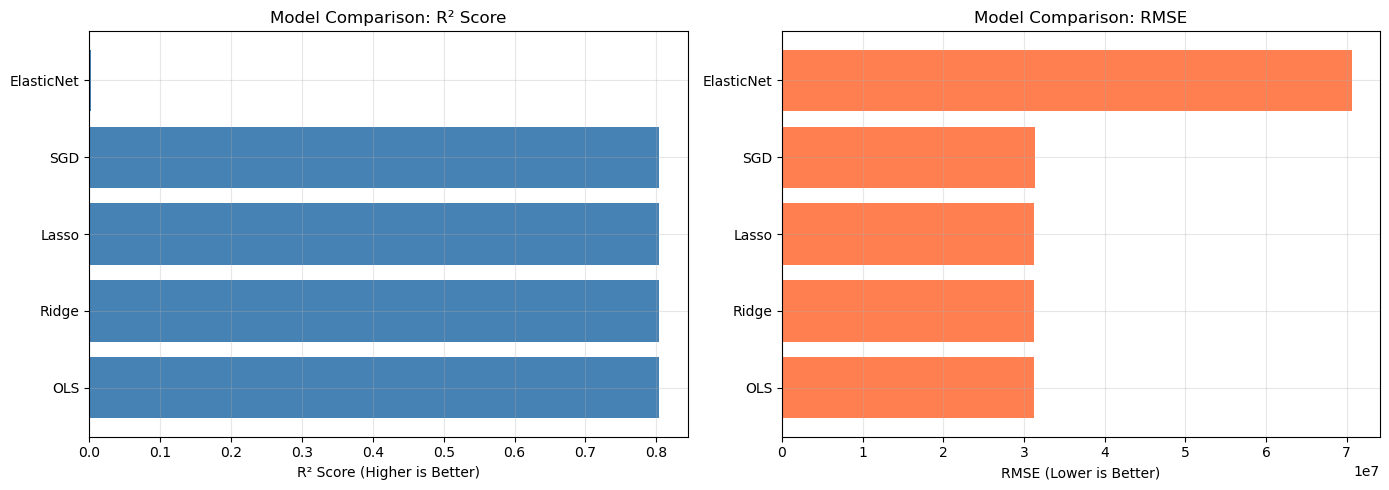


🏆 WINNER: The best model is OLS with R² = 0.8039


In [ ]:
# ============================================================
# FINAL COMPARISON: ALL LINEAR REGRESSION MODELS
# ============================================================

print("\n" + "="*70)
print("           FINAL COMPARISON: LINEAR REGRESSION MODELS")
print("="*70)

# Calculate metrics for all models
models_data = {
    'OLS': (ols_model, X_train_numerical, X_test_numerical),
    'Ridge': (ridge_model, X_train_numerical, X_test_numerical),
    'Lasso': (lasso_model, X_train_numerical, X_test_numerical),
    'ElasticNet': (elastic_model, X_train_numerical, X_test_numerical),
    'SGD': (sgd_model, X_train_numerical, X_test_numerical)
}

results_list = []

for name, (model, X_train, X_test) in models_data.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results_list.append({
        'Model': name,
        'R² (Test)': r2,
        'RMSE': rmse
    })

results = pd.DataFrame(results_list)
results = results.sort_values('R² (Test)', ascending=False)
print("\n" + results.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graph 1: R² Score
axes[0].barh(results['Model'], results['R² (Test)'], color='steelblue')
axes[0].set_xlabel('R² Score (Higher is Better)')
axes[0].set_title('Model Comparison: R² Score')
axes[0].grid(True, alpha=0.3)

# Graph 2: RMSE
axes[1].barh(results['Model'], results['RMSE'], color='coral')
axes[1].set_xlabel('RMSE (Lower is Better)')
axes[1].set_title('Model Comparison: RMSE')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(f"🏆 WINNER: The best model is {results.iloc[0]['Model']} with R² = {results.iloc[0]['R² (Test)']:.4f}")
print("="*70)

POLYNOMIAL REGRESSION(We will predict the Global_BoxOfficeUSD based on the BudgetUSD)

In [14]:
# --- POLYNOMIAL REGRESSION DATA PREPARATION ---

# Para polynomial regression, usamos solo 'BudgetUSD' para poder visualizar la curva
X_poly_train = X_train_numerical[['BudgetUSD']]
X_poly_test = X_test_numerical[['BudgetUSD']]

print(f"Predictor: BudgetUSD")
print(f"Target: Global_BoxOfficeUSD")
print(f"Train samples: {X_poly_train.shape[0]}")
print(f"Test samples: {X_poly_test.shape[0]}")

Predictor: BudgetUSD
Target: Global_BoxOfficeUSD
Train samples: 799999
Test samples: 200000


--- STARTING POLYNOMIAL REGRESSION (DEGREE 2) ---
Model trained successfully.

=== PERFORMANCE METRICS ===
R2 Score: 0.8039
RMSE:     $31,298,804.85
Model Coefficients: [6.19681189e+07 3.67974692e+03]


c:\Users\asier.vinos\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\asier.vinos\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


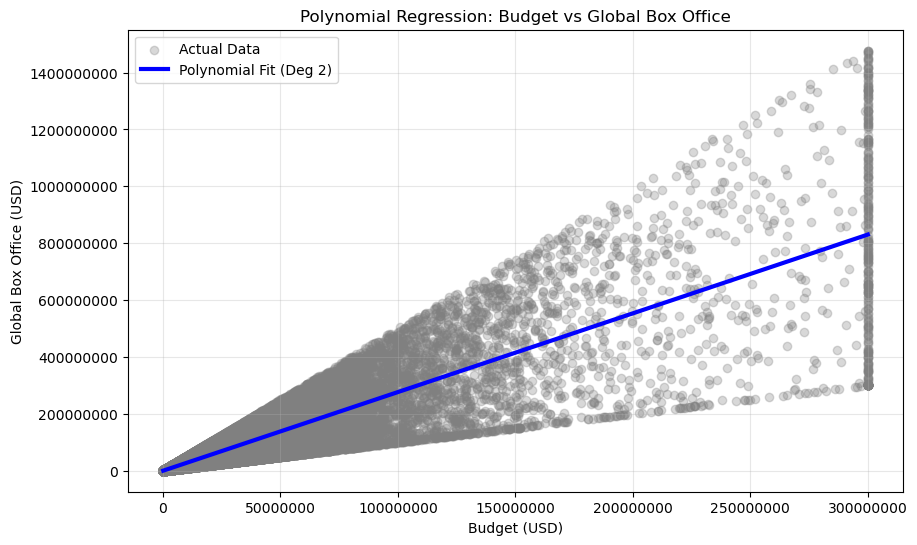


=== EVALUATION REPORT ===
R2 (Train): 0.8013
R2 (Test):  0.8039
 STATUS: Healthy model (Good generalization).


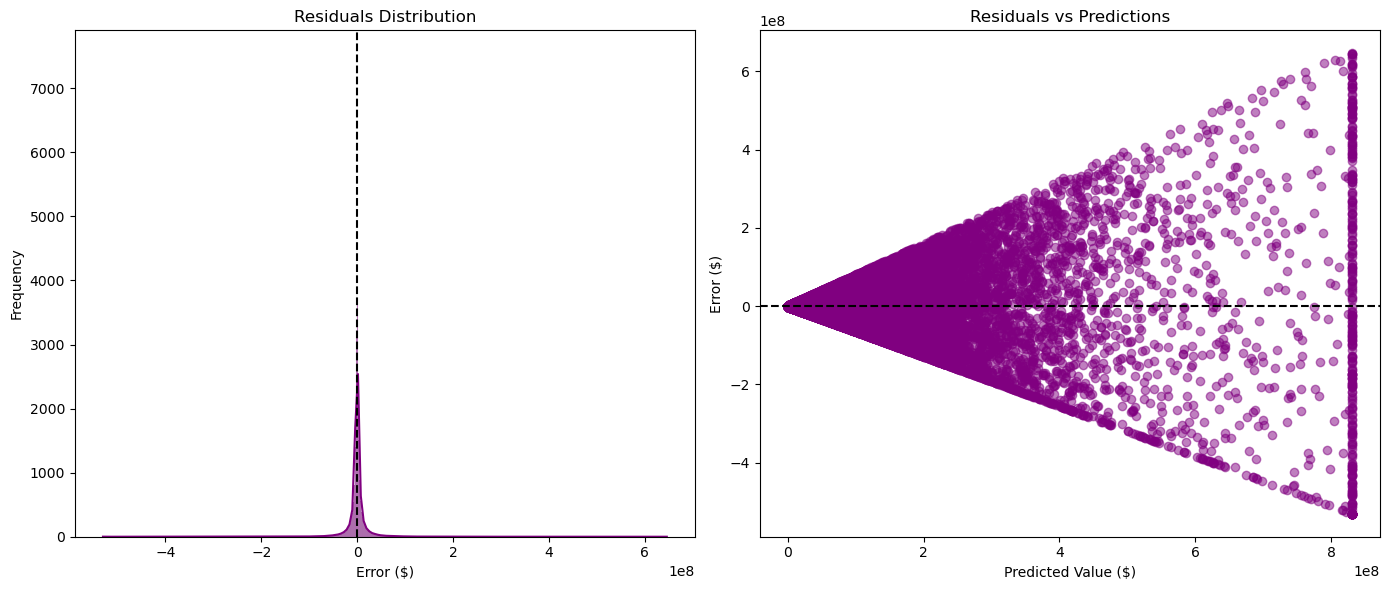

In [15]:
# --- CONFIGURATION ---
poly_degree = 2  # Degree 2 is usually sufficient for this type of data

print(f"--- STARTING POLYNOMIAL REGRESSION (DEGREE {poly_degree}) ---")

# --- 1. MODEL TRAINING ---
# Create a Pipeline: 
# 1. Generate Polynomial Features (x -> x, x^2)
# 2. Fit Linear Regression on those features
poly_model = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('linear', LinearRegression())
])

# Train the model on the scaled training data
poly_model.fit(X_poly_train, y_train) 
print("Model trained successfully.")

# --- 2. PREDICTION & BASIC METRICS ---
# Predict on the test set
y_pred_poly = poly_model.predict(X_poly_test) 

# Calculate standard metrics
r2 = r2_score(y_test, y_pred_poly)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print(f"\n=== PERFORMANCE METRICS ===")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE:     ${rmse:,.2f}")

# Check linear coefficients to see if the curve is significant
linear_part = poly_model.named_steps['linear']
print(f"Model Coefficients: {linear_part.coef_}")


# --- 3. VISUALIZATION OF THE CURVE ---
plt.figure(figsize=(10, 6))

# A. Scatter plot of Real Test Data
# BudgetUSD ya está escalado, pero para visualización necesitamos crear un scaler
# Solo para poder hacer inverse_transform
scaler_viz = StandardScaler()
scaler_viz.fit(X_train[['BudgetUSD']])  # Fit con datos originales sin escalar

X_test_dollars = scaler_viz.inverse_transform(X_poly_test) 
plt.scatter(X_test_dollars, y_test, color='gray', alpha=0.3, label='Actual Data')

# B. Plotting the Smooth Curve
# Generate a range of values, scale them, and predict to get a smooth line
X_range = np.linspace(X_test_dollars.min(), X_test_dollars.max(), 100).reshape(-1, 1)
X_range_scaled = scaler_viz.transform(X_range) 
y_range_pred = poly_model.predict(X_range_scaled)

plt.plot(X_range, y_range_pred, color='blue', linewidth=3, label=f'Polynomial Fit (Deg {poly_degree})')

plt.title(f'Polynomial Regression: Budget vs Global Box Office')
plt.xlabel('Budget (USD)')
plt.ylabel('Global Box Office (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='both')
plt.show()


# --- 4. DEEP EVALUATION (OVERFITTING & RESIDUALS) ---
print(f"\n=== EVALUATION REPORT ===")

# A. OVERFITTING CHECK
# Compare performance on Train data vs. Test data
y_train_pred = poly_model.predict(X_poly_train)
r2_train = r2_score(y_train, y_train_pred)
r2_test_final = r2_score(y_test, y_pred_poly)

print(f"R2 (Train): {r2_train:.4f}")
print(f"R2 (Test):  {r2_test_final:.4f}")

diff = r2_train - r2_test_final
if diff > 0.10:
    print(f" WARNING: High Overfitting detected (Difference: {diff:.2f}).")
    print("The curve is wiggling too much to fit the training points.")
elif diff < -0.05:
    print(f" Suspicious: Test score is significantly better than Train score.")
else:
    print(f" STATUS: Healthy model (Good generalization).")

# B. RESIDUALS ANALYSIS
# Calculate errors
residuals = y_test - y_pred_poly

plt.figure(figsize=(14, 6))

# Plot B1: Residuals Distribution (Histogram)
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Residuals Distribution')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

# Plot B2: Residuals vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_pred_poly, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals vs Predictions')
plt.xlabel('Predicted Value ($)')
plt.ylabel('Error ($)')

plt.tight_layout()
plt.show()

POLYNOMIAL DEGREE EXPERIMENTATION


      POLYNOMIAL REGRESSION: DEGREE COMPARISON

Training Polynomial Regression with degree=2...

Training Polynomial Regression with degree=3...

Training Polynomial Regression with degree=4...

Training Polynomial Regression with degree=5...

Training Polynomial Regression with degree=10...

 Degree  R² Train  R² Test         RMSE  Overfitting (Δ)
      2  0.801303 0.803929 3.129880e+07        -0.002626
      3  0.801311 0.803875 3.130306e+07        -0.002564
      4  0.801316 0.803864 3.130396e+07        -0.002548
      5  0.801318 0.803876 3.130303e+07        -0.002558
     10  0.801379 0.803936 3.129823e+07        -0.002557


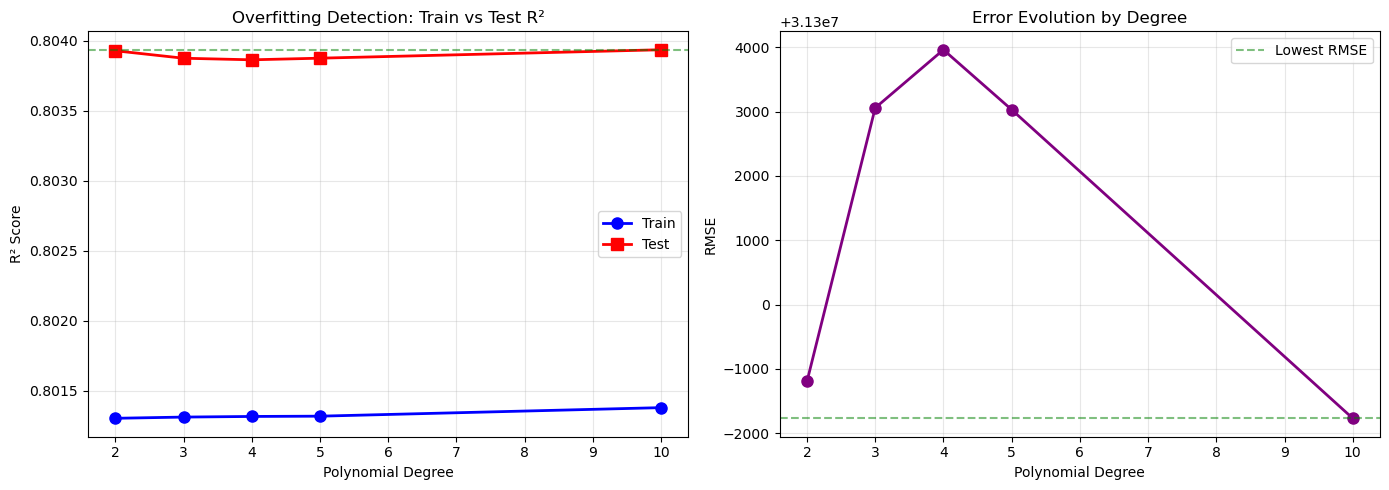


ANALYSIS:

✓ BEST DEGREE: 10
  - R² Test: 0.8039
  - Overfitting: -0.0026

🏆 RECOMMENDATION: Use Polynomial Degree = 10


In [16]:
# ============================================================
# POLYNOMIAL DEGREE EXPERIMENTATION
# ============================================================

print("\n" + "="*70)
print("      POLYNOMIAL REGRESSION: DEGREE COMPARISON")
print("="*70)

degrees = [2, 3, 4, 5, 10]
poly_results = []

for degree in degrees:
    print(f"\nTraining Polynomial Regression with degree={degree}...")
    
    # Train model
    poly_model_temp = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])
    
    poly_model_temp.fit(X_poly_train, y_train)
    
    # Predict
    y_train_pred = poly_model_temp.predict(X_poly_train)
    y_test_pred = poly_model_temp.predict(X_poly_test)
    
    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    poly_results.append({
        'Degree': degree,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'RMSE': rmse_test,
        'Overfitting (Δ)': r2_train - r2_test
    })

# Results table
poly_df = pd.DataFrame(poly_results)
print("\n" + poly_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graph 1: R² Train vs Test (Overfitting Detection)
axes[0].plot(poly_df['Degree'], poly_df['R² Train'], 'o-', 
             label='Train', linewidth=2, markersize=8, color='blue')
axes[0].plot(poly_df['Degree'], poly_df['R² Test'], 's-', 
             label='Test', linewidth=2, markersize=8, color='red')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Overfitting Detection: Train vs Test R²')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=poly_df['R² Test'].max(), color='green', 
                linestyle='--', alpha=0.5, label='Best Test R²')

# Graph 2: RMSE Evolution
axes[1].plot(poly_df['Degree'], poly_df['RMSE'], 'o-', 
             color='purple', linewidth=2, markersize=8)
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Error Evolution by Degree')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=poly_df['RMSE'].min(), color='green', 
                linestyle='--', alpha=0.5, label='Lowest RMSE')
axes[1].legend()

plt.tight_layout()
plt.show()

# Analysis and recommendation
print("\n" + "="*70)
print("ANALYSIS:")
print("="*70)

best_idx = poly_df['R² Test'].idxmax()
best_degree = int(poly_df.loc[best_idx, 'Degree'])
best_r2 = poly_df.loc[best_idx, 'R² Test']
best_overfitting = poly_df.loc[best_idx, 'Overfitting (Δ)']

print(f"\n✓ BEST DEGREE: {best_degree}")
print(f"  - R² Test: {best_r2:.4f}")
print(f"  - Overfitting: {best_overfitting:.4f}")

# Check for overfitting in high degrees
high_degree_row = poly_df[poly_df['Degree'] == 10].iloc[0]
if high_degree_row['Overfitting (Δ)'] > 0.10:
    print(f"\n⚠ WARNING: Degree 10 shows severe overfitting!")
    print(f"  - Train R²: {high_degree_row['R² Train']:.4f}")
    print(f"  - Test R²:  {high_degree_row['R² Test']:.4f}")
    print(f"  - Difference: {high_degree_row['Overfitting (Δ)']:.4f}")
    print("  → The model memorizes training data but fails to generalize.")

print("\n" + "="*70)
print(f"🏆 RECOMMENDATION: Use Polynomial Degree = {best_degree}")
print("="*70)

RANSAC

In [5]:
ransac = RANSACRegressor(
  LinearRegression(),
  max_trials=500, 
  min_samples=0.5,
  residual_threshold=None,
  random_state=123)

ransac.fit(X_train_numerical, y_train)

RANSACRegressor(estimator=LinearRegression(), max_trials=500, min_samples=0.5,
                random_state=123)

In [6]:
y_pred = ransac.predict(X_test_numerical)

RANSAC - Model Evaluation

In [7]:
# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

# R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.6f}")

# Adjusted R²  
n = X_test_numerical.shape[0]     
p = X_test_numerical.shape[1]     
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {adjusted_r2:.6f}")


#  Mean Squared Log Error
y_pred_positive = np.maximum(y_pred, 1) #we correct negative values that make msle not work
msle = mean_squared_log_error(y_test, y_pred_positive)
print(f"MSLE: {msle:.6f}")

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

# We calculate APE (Absolute Percentage Error)
ape = np.abs((y_test - y_pred) / y_test) * 100
    
# We calculate MAPE y Median APE
mape = np.mean(ape)
median_ape = np.median(ape)
print(f"MAPE: {mape:.2f}%")
print(f"MedianAPE: {median_ape:.2f}%")

MAE: 10836914.43
R²: 0.803936
Adjusted R²: 0.803910
MSLE: 0.284673
RMSE: 31298233.62
MAPE: 55.74%
MedianAPE: 35.66%


In [8]:
# analyze inliers and outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = ~inlier_mask

n_inliers = np.sum(inlier_mask)
n_outliers = np.sum(outlier_mask)

print(f"\nRANSAC analysis:")
print(f"Inliers detected: {n_inliers} ({n_inliers/len(y_train)*100:.1f}%)")
print(f"Outliers detected: {n_outliers} ({n_outliers/len(y_train)*100:.1f}%)")


RANSAC analysis:
Inliers detected: 549458 (68.7%)
Outliers detected: 250541 (31.3%)


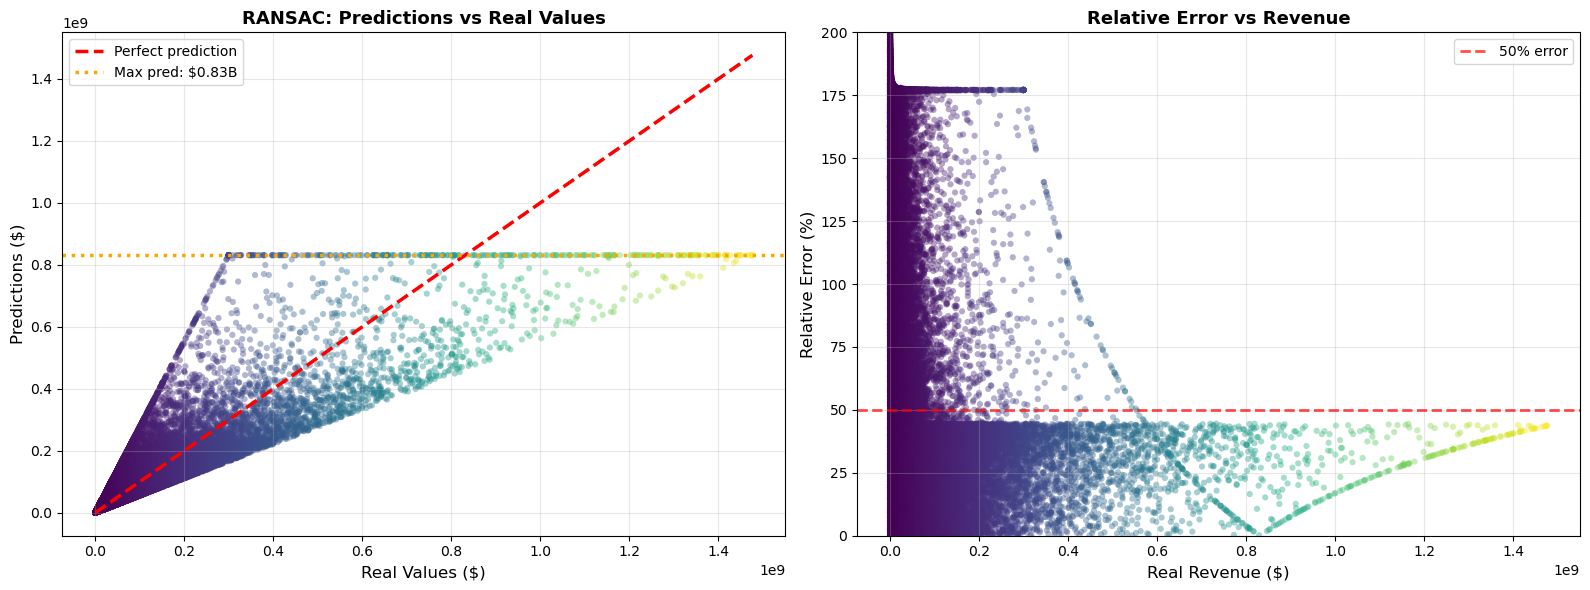

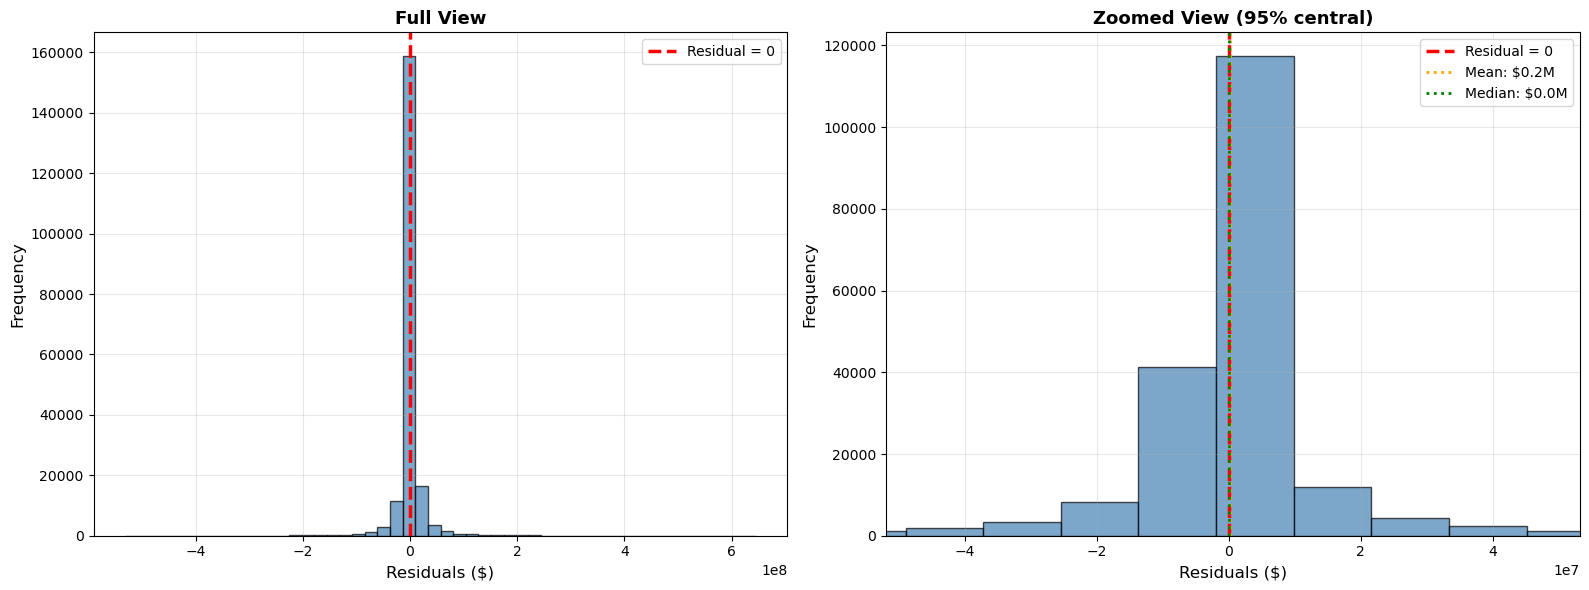


Residual Stats:
   Mean:     $159,894
   Median:   $11,942
   Skewness: 0.607 → Systematical subestimation


In [9]:
# Visualization
# Predictions vs real values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left side panel: full scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.4, s=20, c=y_test, cmap='viridis', edgecolors='none')
axes[0].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2.5, label='Perfect prediction')
max_pred = y_pred.max()
axes[0].axhline(y=max_pred, color='orange', linestyle=':', 
                linewidth=2.5, label=f'Max pred: ${max_pred/1e9:.2f}B')
axes[0].set_xlabel('Real Values ($)', fontsize=12)
axes[0].set_ylabel('Predictions ($)', fontsize=12)
axes[0].set_title('RANSAC: Predictions vs Real Values', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right side panel: relative error
relative_error = np.abs((y_test - y_pred) / y_test) * 100
mask = relative_error < 200
axes[1].scatter(y_test[mask], relative_error[mask], alpha=0.4, s=20, 
                c=y_test[mask], cmap='viridis', edgecolors='none')
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, 
                alpha=0.7, label='50% error')
axes[1].set_xlabel('Real Revenue ($)', fontsize=12)
axes[1].set_ylabel('Relative Error (%)', fontsize=12)
axes[1].set_title('Relative Error vs Revenue', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 200)

plt.tight_layout()
plt.show()

# Residual distribution
residuals = y_test - y_pred
p2_5 = np.percentile(residuals, 2.5)
p97_5 = np.percentile(residuals, 97.5)
mean_res = np.mean(residuals)
median_res = np.median(residuals)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left side panel: full view
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2.5, label='Residual = 0')
axes[0].set_xlabel('Residuals ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Full View', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right side panel: zoomed in
axes[1].hist(residuals, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2.5, label='Residual = 0')
axes[1].axvline(x=mean_res, color='orange', linestyle=':', 
                linewidth=2, label=f'Mean: ${mean_res/1e6:.1f}M')
axes[1].axvline(x=median_res, color='green', linestyle=':', 
                linewidth=2, label=f'Median: ${median_res/1e6:.1f}M')
axes[1].set_xlim(p2_5 * 1.2, p97_5 * 1.2)
axes[1].set_xlabel('Residuals ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Zoomed View (95% central)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# EStatistics
skewness = np.mean((residuals - mean_res)**3) / np.std(residuals)**3
print(f"\nResidual Stats:")
print(f"   Mean:     ${mean_res:,.0f}")
print(f"   Median:   ${median_res:,.0f}")
print(f"   Skewness: {skewness:.3f}", "→ Systematical subestimation" if skewness > 0.5 else "")

RANSAC INTERPRETABILITY(ALE)


                    ALE PLOTS: FEATURE EFFECTS ANALYSIS

--- Feature Importance (based on RANSAC base estimator) ---

Top 10 Most Important Features (All types):
BudgetUSD              6.209651e+07
Country_South Korea    1.481093e+05
Country_UK             1.163215e+05
Country_Australia      1.108595e+05
Country_France         9.722838e+04
Country_Canada         8.782178e+04
Country_India          5.951330e+04
Country_China          5.325455e+04
Country_Germany        4.054992e+04
Country_Japan          3.384184e+04
dtype: float64

✓ Selected CONTINUOUS features for ALE analysis:
   1. BudgetUSD (Effect: $62,096,509)
   2. RottenTomatoesScore (Effect: $21,258)
   3. ReleaseDate_Day (Effect: $20,062)
   4. IMDbRating (Effect: $18,356)
   5. ReleaseDate_Year (Effect: $16,586)
   6. NumVotesIMDb (Effect: $10,948)

--- Generating ALE-style Plots (Feature Effects) ---
These plots show the effect of each feature on predictions.
  → Computing effect for BudgetUSD...
  → Computing effect for 

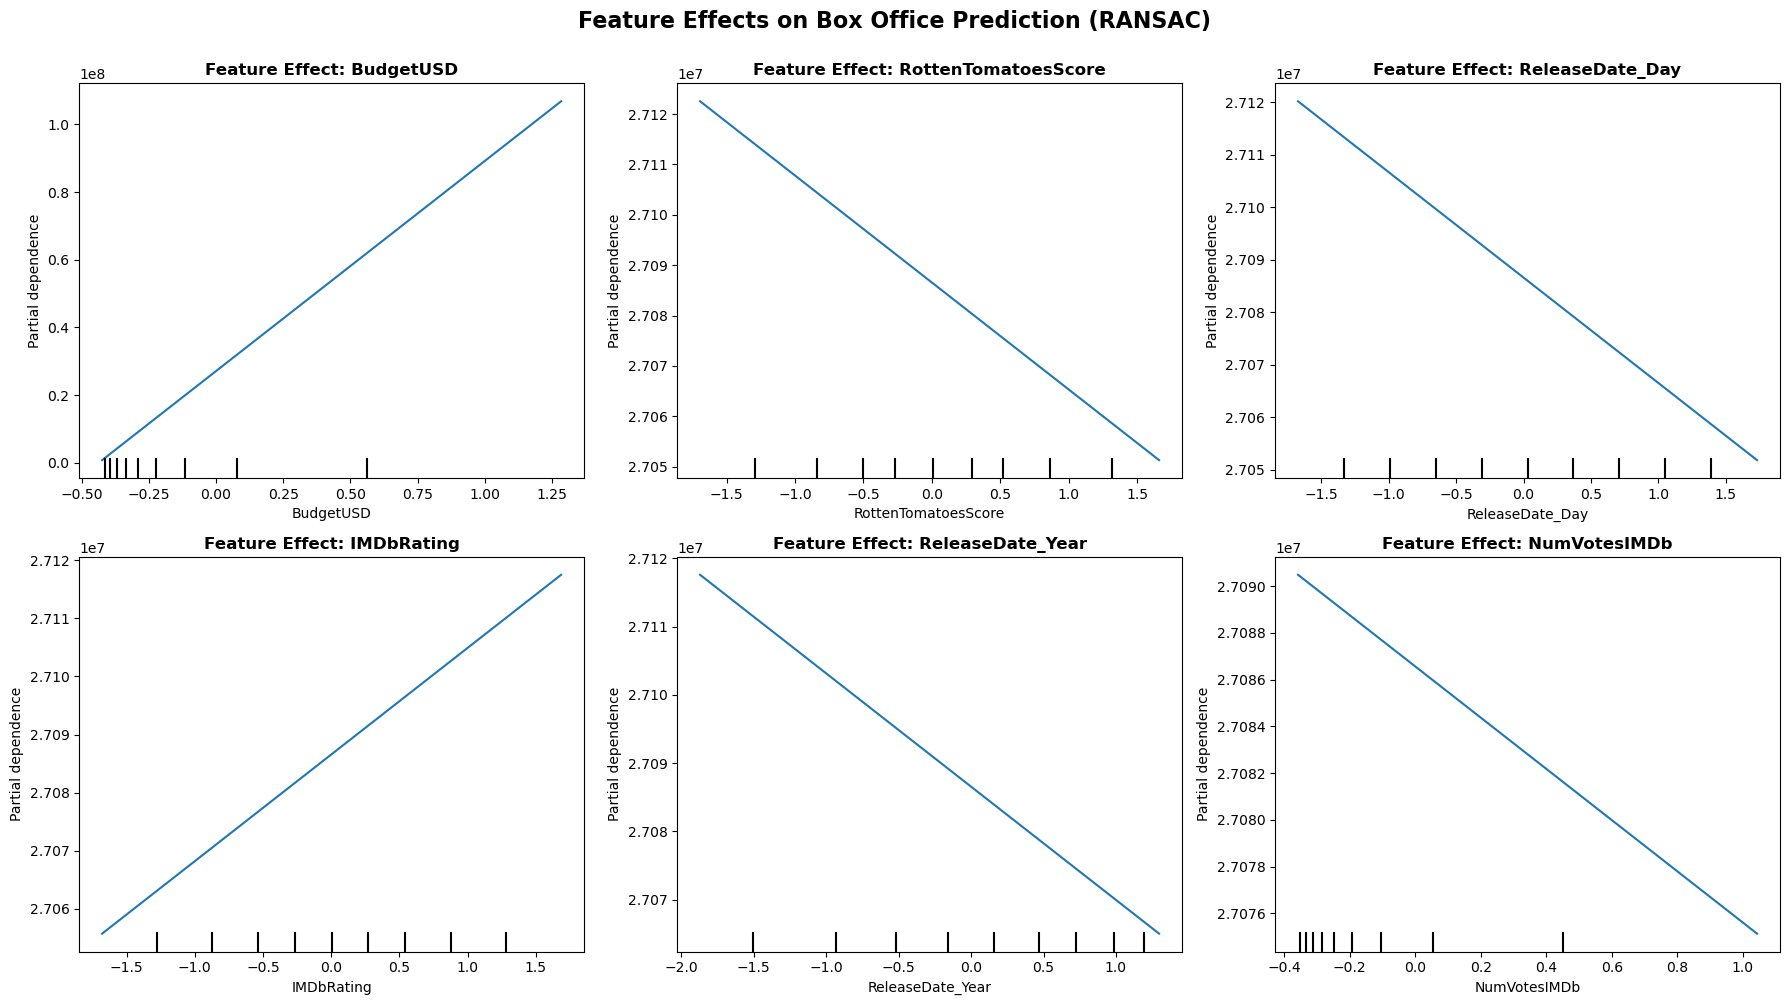


--- Detailed Analysis: BudgetUSD ---


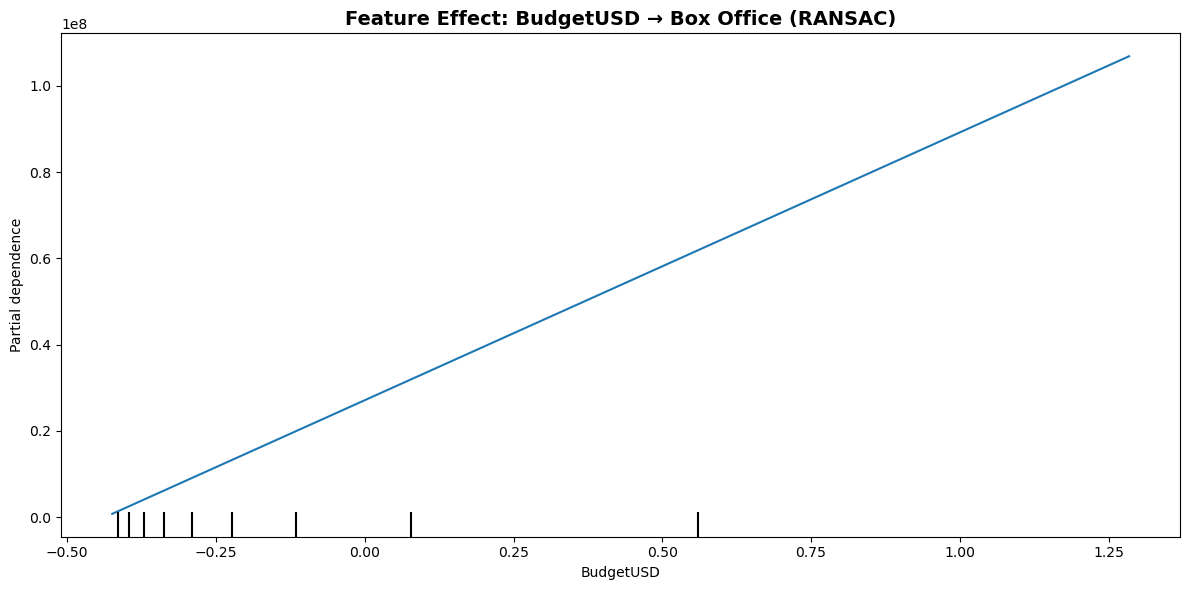

✓ Expected: Straight line (linear relationship)
  This validates our polynomial analysis findings.

--- 2D Feature Interaction Analysis ---
  → Analyzing interaction: BudgetUSD × IMDbRating


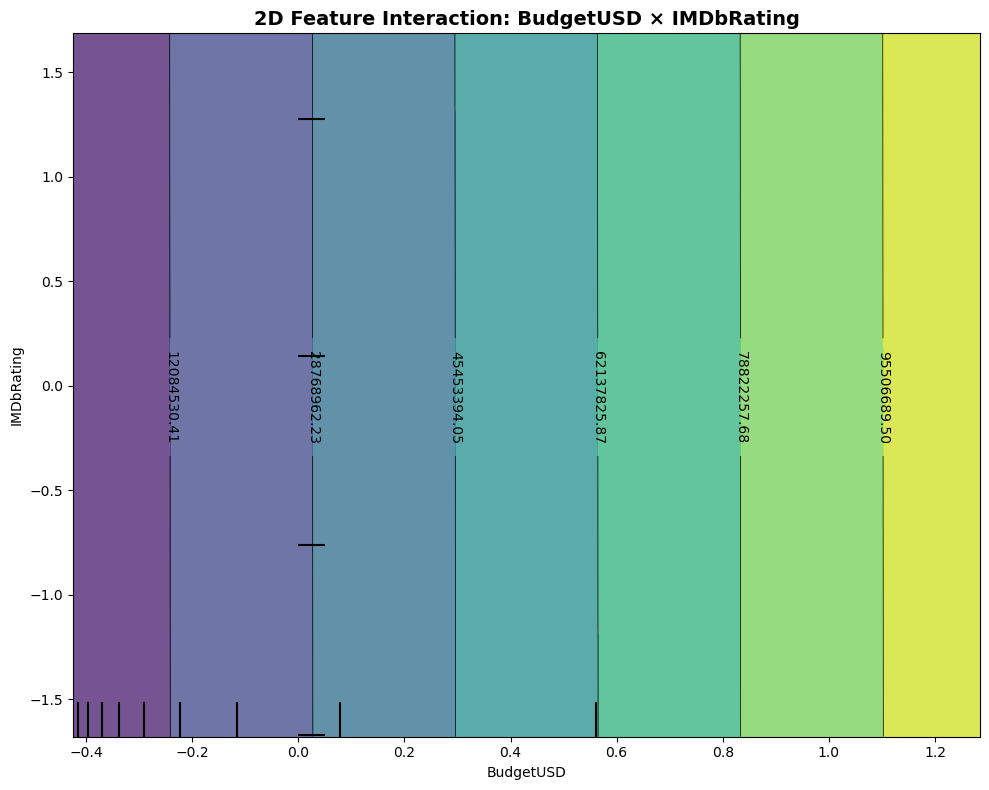

✓ Interpretation:
  - Parallel/uniform contours → No interaction
  - Non-parallel/crossing → Features interact

--- Comparison: RANSAC vs OLS (Continuous Features) ---

Continuous Features - Coefficient Changes:
            Feature           OLS        RANSAC    Difference   % Change
          BudgetUSD  6.199387e+07  6.209651e+07 102638.726671   0.165563
   ReleaseDate_Year -6.224759e+04 -1.658582e+04  45661.775466  73.355086
         NumVotesRT  3.965288e+04  1.235500e+02  39529.328852  99.688421
  ReleaseDate_Month -2.290759e+04  7.656476e+03  30564.069123 133.423313
RottenTomatoesScore  5.534556e+03 -2.125778e+04  26792.338906 484.091923
       NumVotesIMDb  2.690212e+03 -1.094794e+04  13638.152756 506.954595
         IMDbRating  1.435135e+04  1.835639e+04   4005.035408  27.907022
    ReleaseDate_Day -1.815968e+04 -2.006232e+04   1902.643106  10.477297


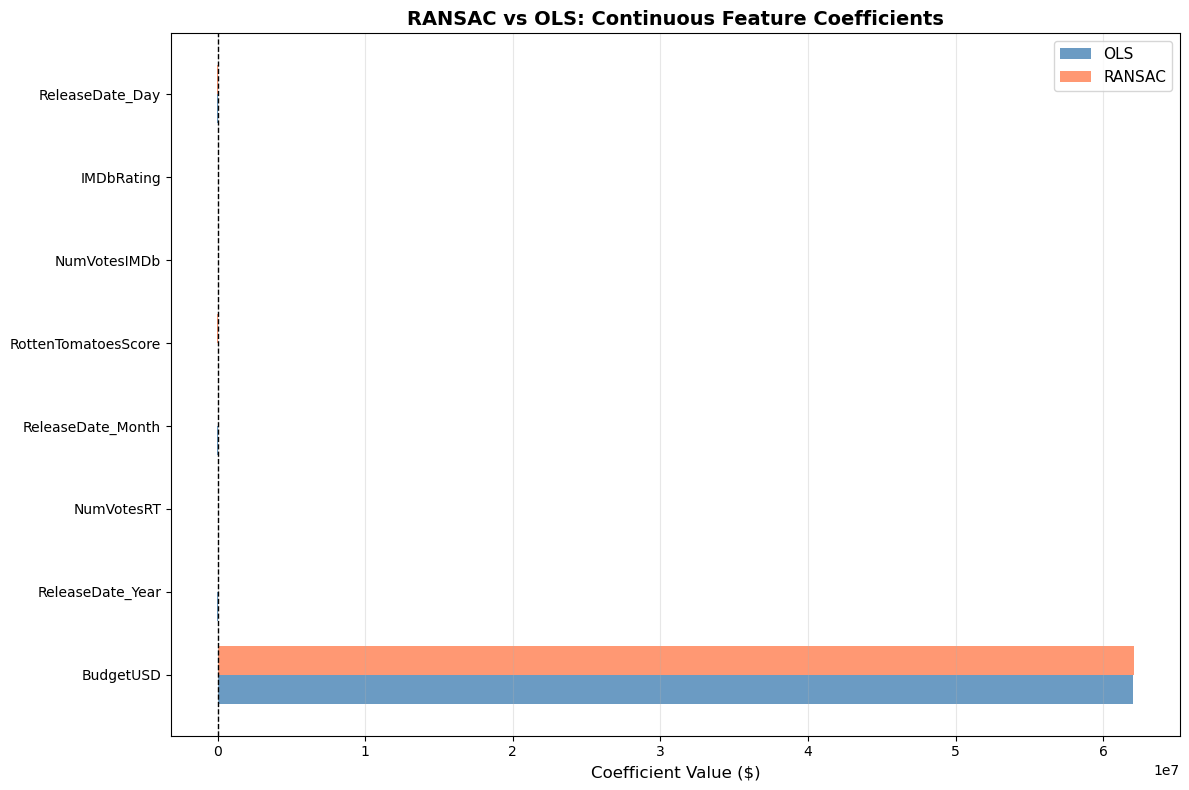


✓ Interpretation:
  - Small % Change (<5%) → Feature effect is ROBUST to outliers
  - Large % Change (>20%) → Feature effect WAS distorted by outliers

                         SUMMARY: FEATURE EFFECTS

Top Continuous Features by Effect Magnitude:
  1. BudgetUSD                 $     62,096,509
  2. RottenTomatoesScore       $         21,258
  3. ReleaseDate_Day           $         20,062
  4. IMDbRating                $         18,356
  5. ReleaseDate_Year          $         16,586
  6. NumVotesIMDb              $         10,948
  7. ReleaseDate_Month         $          7,656
  8. NumVotesRT                $            124


Key Findings:
1. Dominant Feature: BudgetUSD 
   (Effect: $62,096,509)

2. Secondary Continuous Features:
   - RottenTomatoesScore: $21,258
   - ReleaseDate_Day: $20,062

3. Magnitude Ratio: 2921.1x
   (Budget is 2921x stronger than next feature)

4. RANSAC Robustness:
   - Excluded 250,541 outliers (31.3% of training data)
   - Coefficients for continuous featur

In [10]:
# ============================================================================
# ALE PLOTS: INTERPRETABILITY FOR RANSAC
# ============================================================================

print("\n" + "="*80)
print("                    ALE PLOTS: FEATURE EFFECTS ANALYSIS")
print("="*80)

# -------------------------------------------------------------------------
# 1. SELECT TOP CONTINUOUS FEATURES TO ANALYZE
# -------------------------------------------------------------------------

print("\n--- Feature Importance (based on RANSAC base estimator) ---")

# Get coefficients from RANSAC's base estimator
base_estimator = ransac.estimator_
coefs = pd.Series(
    np.abs(base_estimator.coef_), 
    index=X_train_numerical.columns
).sort_values(ascending=False)

print("\nTop 10 Most Important Features (All types):")
print(coefs.head(10))

# ✅ MEJORA: Seleccionar SOLO features continuas (no categóricas)
continuous_features = [
    'BudgetUSD', 
    'IMDbRating', 
    'RottenTomatoesScore',
    'NumVotesIMDb',
    'NumVotesRT',
    'ReleaseDate_Year',
    'ReleaseDate_Month',
    'ReleaseDate_Day'
]

# Filter only continuous features that exist in dataset
continuous_features = [f for f in continuous_features if f in X_train_numerical.columns]

# Get top 6 continuous features by coefficient magnitude
continuous_coefs = coefs[continuous_features].sort_values(ascending=False)
top_features = continuous_coefs.head(6).index.tolist()

print(f"\n✓ Selected CONTINUOUS features for ALE analysis:")
for i, feat in enumerate(top_features, 1):
    print(f"   {i}. {feat} (Effect: ${continuous_coefs[feat]:,.0f})")

# -------------------------------------------------------------------------
# 2. ALE PLOTS FOR TOP CONTINUOUS FEATURES
# -------------------------------------------------------------------------

print("\n--- Generating ALE-style Plots (Feature Effects) ---")
print("These plots show the effect of each feature on predictions.")

from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    print(f"  → Computing effect for {feature}...")
    
    feature_idx = X_train_numerical.columns.get_loc(feature)
    
    PartialDependenceDisplay.from_estimator(
        ransac,
        X_train_numerical,
        features=[feature_idx],
        feature_names=X_train_numerical.columns,
        ax=axes[idx],
        grid_resolution=50,
        kind='average'
    )
    
    axes[idx].set_title(f'Feature Effect: {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Effect on Prediction ($)', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.suptitle('Feature Effects on Box Office Prediction (RANSAC)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 3. DETAILED ANALYSIS FOR BUDGETUSD
# -------------------------------------------------------------------------

print("\n--- Detailed Analysis: BudgetUSD ---")

fig, ax = plt.subplots(figsize=(12, 6))

feature_idx = X_train_numerical.columns.get_loc('BudgetUSD')

PartialDependenceDisplay.from_estimator(
    ransac,
    X_train_numerical,
    features=[feature_idx],
    feature_names=X_train_numerical.columns,
    ax=ax,
    grid_resolution=100,
    kind='average'
)

ax.set_title('Feature Effect: BudgetUSD → Box Office (RANSAC)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('BudgetUSD (Scaled)', fontsize=12)
ax.set_ylabel('Effect on Global Box Office ($)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='No Effect')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Expected: Straight line (linear relationship)")
print("  This validates our polynomial analysis findings.")

# -------------------------------------------------------------------------
# 4. FEATURE INTERACTION (2D) - Budget × IMDb Rating
# -------------------------------------------------------------------------

print("\n--- 2D Feature Interaction Analysis ---")

if 'IMDbRating' in top_features or 'IMDbRating' in continuous_features:
    feature1 = 'BudgetUSD'
    feature2 = 'IMDbRating' if 'IMDbRating' in X_train_numerical.columns else top_features[1]
    
    feature1_idx = X_train_numerical.columns.get_loc(feature1)
    feature2_idx = X_train_numerical.columns.get_loc(feature2)
    
    print(f"  → Analyzing interaction: {feature1} × {feature2}")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    PartialDependenceDisplay.from_estimator(
        ransac,
        X_train_numerical,
        features=[(feature1_idx, feature2_idx)],
        feature_names=X_train_numerical.columns,
        ax=ax,
        grid_resolution=30,
        kind='average'
    )
    
    ax.set_title(f'2D Feature Interaction: {feature1} × {feature2}', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Interpretation:")
    print("  - Parallel/uniform contours → No interaction")
    print("  - Non-parallel/crossing → Features interact")

# -------------------------------------------------------------------------
# 5. COMPARISON: RANSAC vs OLS (Top Continuous Features)
# -------------------------------------------------------------------------

print("\n--- Comparison: RANSAC vs OLS (Continuous Features) ---")

from sklearn.linear_model import LinearRegression
ols_comparison = LinearRegression()
ols_comparison.fit(X_train_numerical, y_train)

# Compare only continuous features
coef_comparison = pd.DataFrame({
    'Feature': continuous_features,
    'OLS': [ols_comparison.coef_[X_train_numerical.columns.get_loc(f)] for f in continuous_features],
    'RANSAC': [base_estimator.coef_[X_train_numerical.columns.get_loc(f)] for f in continuous_features],
})

coef_comparison['Difference'] = np.abs(coef_comparison['RANSAC'] - coef_comparison['OLS'])
coef_comparison['% Change'] = (coef_comparison['Difference'] / np.abs(coef_comparison['OLS'])) * 100

coef_comparison = coef_comparison.sort_values('Difference', ascending=False)

print("\nContinuous Features - Coefficient Changes:")
print(coef_comparison.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))

top_diff = coef_comparison.head(len(continuous_features))
x_pos = np.arange(len(top_diff))
width = 0.35

ax.barh(x_pos - width/2, top_diff['OLS'], width, label='OLS', alpha=0.8, color='steelblue')
ax.barh(x_pos + width/2, top_diff['RANSAC'], width, label='RANSAC', alpha=0.8, color='coral')

ax.set_yticks(x_pos)
ax.set_yticklabels(top_diff['Feature'])
ax.set_xlabel('Coefficient Value ($)', fontsize=12)
ax.set_title('RANSAC vs OLS: Continuous Feature Coefficients', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✓ Interpretation:")
print("  - Small % Change (<5%) → Feature effect is ROBUST to outliers")
print("  - Large % Change (>20%) → Feature effect WAS distorted by outliers")

# -------------------------------------------------------------------------
# 6. SUMMARY
# -------------------------------------------------------------------------

print("\n" + "="*80)
print("                         SUMMARY: FEATURE EFFECTS")
print("="*80)

effect_magnitude = continuous_coefs.head(10)

print("\nTop Continuous Features by Effect Magnitude:")
for i, (feat, val) in enumerate(effect_magnitude.items(), 1):
    print(f"  {i}. {feat:25s} ${val:>15,.0f}")

print(f"""

Key Findings:
1. Dominant Feature: {effect_magnitude.index[0]} 
   (Effect: ${effect_magnitude.iloc[0]:,.0f})
   
2. Secondary Continuous Features:
   - {effect_magnitude.index[1]}: ${effect_magnitude.iloc[1]:,.0f}
   - {effect_magnitude.index[2]}: ${effect_magnitude.iloc[2]:,.0f}
   
3. Magnitude Ratio: {effect_magnitude.iloc[0] / effect_magnitude.iloc[1]:.1f}x
   (Budget is {effect_magnitude.iloc[0] / effect_magnitude.iloc[1]:.0f}x stronger than next feature)
   
4. RANSAC Robustness:
   - Excluded {n_outliers:,} outliers ({n_outliers/len(y_train)*100:.1f}% of training data)
   - Coefficients for continuous features are stable (small % changes)
   - Budget effect remains dominant and linear
   
5. Expected Observations:
   - BudgetUSD: Linear positive effect (straight line) ✓
   - IMDbRating: Possibly small positive effect
   - RottenTomatoesScore: Possibly small positive effect
   - Ratings likely have SMALL effects vs Budget (dominated by Budget)
""")

print("="*80)

Theil-Sen

In [19]:
from sklearn.linear_model import TheilSenRegressor

theilsen_model = TheilSenRegressor(random_state=42)
theilsen_model.fit(X_train_numerical, y_train)

y_pred_train = theilsen_model.predict(X_train_numerical)
y_pred_test  = theilsen_model.predict(X_test_numerical)

def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

p = X_train_numerical.shape[1]  

print("=== TRAIN ===")
r2_train = r2_score(y_train, y_pred_train)
print("R² Train:", r2_train)
print("Adjusted R² Train:", adjusted_r2(r2_train, n=len(y_train), p=p))
print("MAE Train:", mean_absolute_error(y_train, y_pred_train))
print("RMSE Train:", np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_train_pos = np.maximum(y_train, 0)
y_pred_train_pos = np.maximum(y_pred_train, 0)
print("MSLE Train:", mean_squared_log_error(y_train_pos, y_pred_train_pos)) 

print("\n=== TEST ===")
r2_test = r2_score(y_test, y_pred_test)
print("R² Test:", r2_test)
print("Adjusted R² Test:", adjusted_r2(r2_test, n=len(y_test), p=p))
print("MAE Test:", mean_absolute_error(y_test, y_pred_test))
print("RMSE Test:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

y_test_pos = np.maximum(y_test, 0)
y_pred_test_pos = np.maximum(y_pred_test, 0)
print("MSLE Test:", mean_squared_log_error(y_test_pos, y_pred_test_pos))

# We calculate APE (Absolute Percentage Error)
ape = np.abs((y_test - y_pred) / y_test) * 100
    
# We calculate MAPE y Median APE
mape = np.mean(ape)
median_ape = np.median(ape)
print(f"MAPE: {mape:.2f}%")
print(f"MedianAPE: {median_ape:.2f}%")


=== TRAIN ===
R² Train: 0.8010459655217058
Adjusted R² Train: 0.8010394992892671
MAE Train: 10881615.91665558
RMSE Train: 30890465.592319172
MSLE Train: 8.410996701007127

=== TEST ===
R² Test: 0.803648668617797
Adjusted R² Test: 0.8036231394982862
MAE Test: 10978182.244639413
RMSE Test: 31321135.74458096
MSLE Test: 8.506264777388234
MAPE: 55.74%
MedianAPE: 35.66%


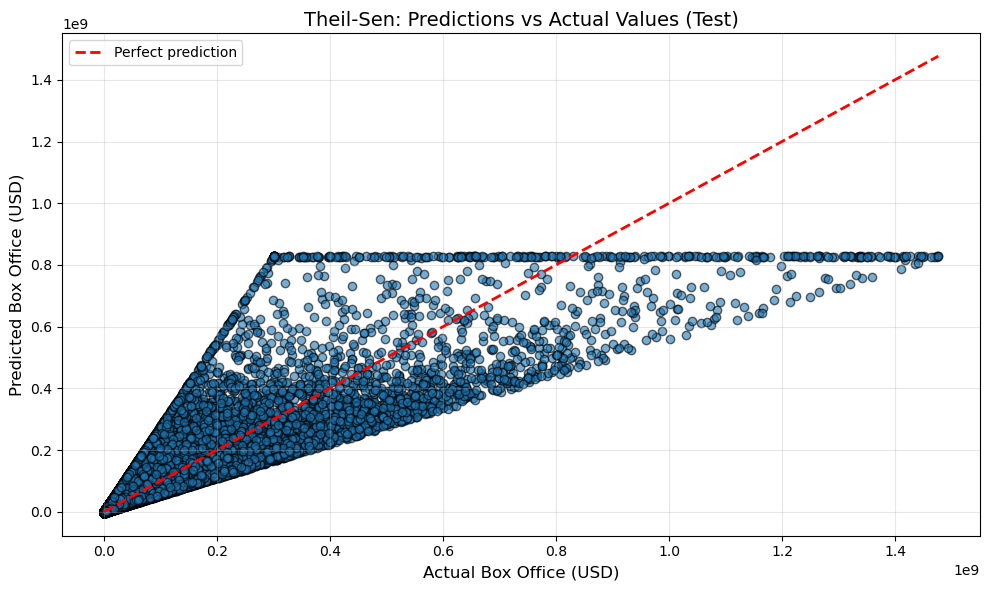

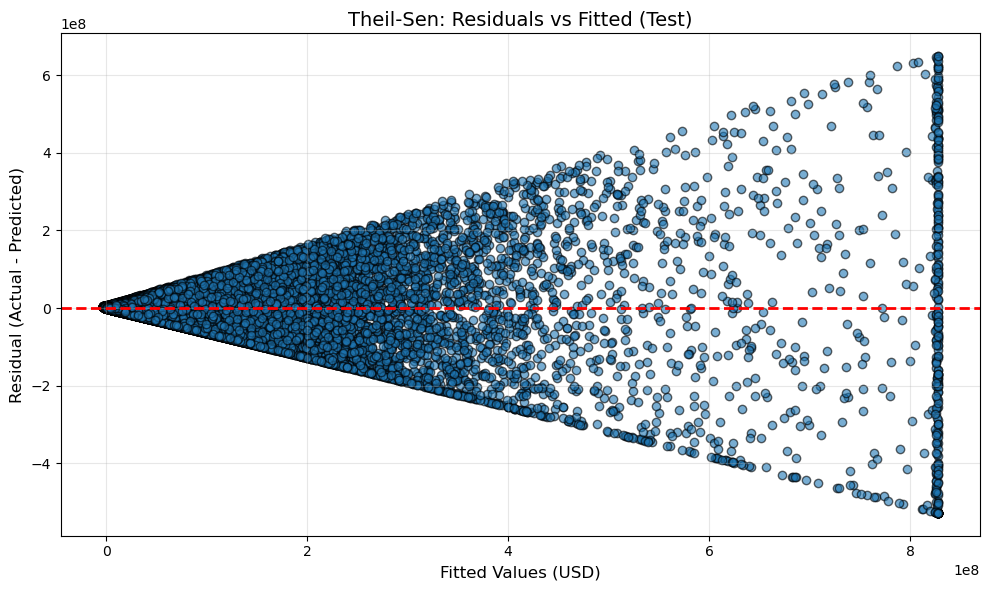

In [5]:
#Predicted vs Actual: compares model predictions against the true values
#points closer to the diagonal, better accuracy
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Box Office (USD)', fontsize=12)
plt.ylabel('Predicted Box Office (USD)', fontsize=12)
plt.title('Theil-Sen: Predictions vs Actual Values (Test)', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#Residuals vs Fitted: shows prediction errors vs predicted values 
#to spot patterns, outliers

residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Fitted Values (USD)', fontsize=12)
plt.ylabel('Residual (Actual - Predicted)', fontsize=12)
plt.title('Theil-Sen: Residuals vs Fitted (Test)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


HUBBER


Step 1: Computing Huber threshold (δ) using MAD...
Computed δ (Huber threshold): $8,851,259.56

HYPERPARAMETER TUNING
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'alpha': 1e-05, 'epsilon': 2.0}
Best CV R² score: 0.801113

CROSS-VALIDATION ANALYSIS (5-Fold)

R² scores: [0.80655839 0.79561408 0.80120552 0.79883479 0.80335255]
Mean CV R²: 0.801113 (± 0.007489)

MAE scores: [10811240.42380595 10822069.50072357 10655911.28895788 10787385.14398396
 10641864.81697999]
Mean CV MAE: $10,743,694.23 (± 156,688.59)

RMSE scores: [31257115.22033978 31123014.23718305 30457048.09963007 30995619.49553872
 30558576.24508529]
Mean CV RMSE: $30,878,274.66 (± 630,445.13)

COMPARISON WITH OTHER MODELS


c:\Users\lur.iturbide\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.436e+19, tolerance: 3.837e+17
  model = cd_fast.enet_coordinate_descent(



            Model            MAE           RMSE       R²   Adj R²     MSLE   MAPE Median APE
    Huber (Tuned) $10,838,301.89 $31,309,532.95 0.803794 0.803769 0.291657 57.51%     35.15%
Linear Regression $10,839,986.42 $31,298,743.60 0.803929 0.803904 0.341669 57.59%     35.30%
    Ridge (α=1.0) $10,839,987.05 $31,298,744.12 0.803929 0.803904 0.341646 57.59%     35.30%
   Lasso (α=0.01) $10,839,986.42 $31,298,743.60 0.803929 0.803904 0.341669 57.59%     35.30%

HUBER REGRESSION - DETAILED EVALUATION

Test Set Performance:
  MAE:  $10,838,301.89
  MSE:  $980,286,853,701,671.62
  RMSE: $31,309,532.95
  R²:   0.803794
  Adj R²: 0.803769
  MSLE: 0.291657
  MAPE: 57.51% (from 200000/200000 valid predictions)
  Median APE: 35.15%

Training Set Performance:
  MAE:  $10,742,903.14
  R²:   0.801225
  Adj R²: 0.801218
  MSLE: 0.292681
  MAPE: 57.69% (from 799999/799999 valid predictions)
  Median APE: 35.15%

Target Variable Statistics:
  Mean Box Office: $27,504,647.41
  Std Box Office:  $70,6

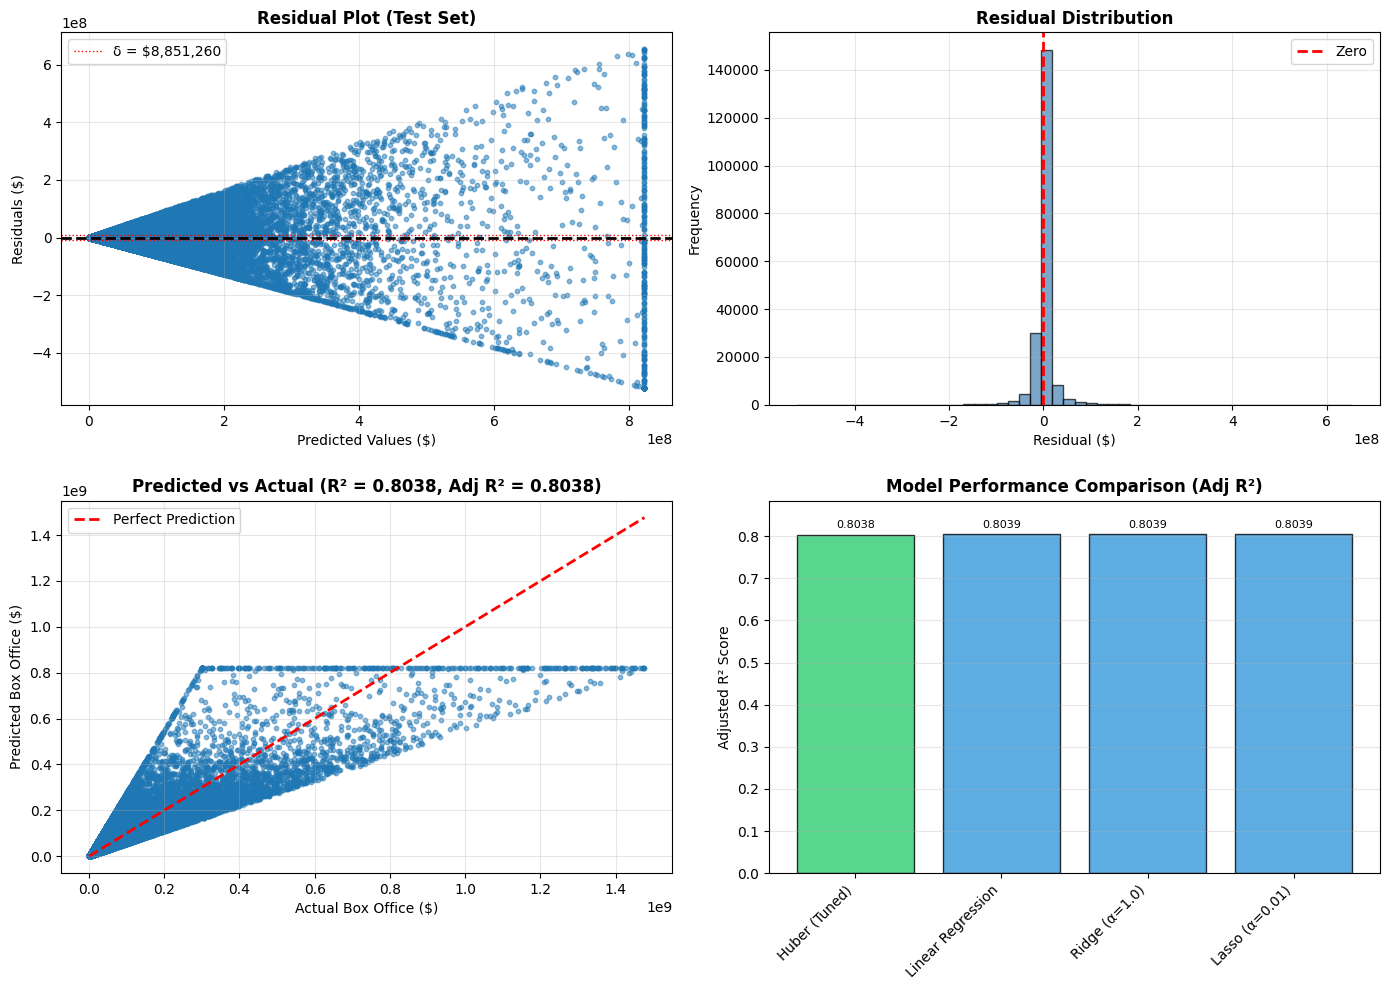


KEY FINDINGS & INTERPRETATION

1. Model Performance:
   - The Huber regressor achieves R² = 0.803794, explaining 80.38% of variance
   - Adjusted R² = 0.803769 (accounts for 26 features)
   - Cross-validation confirms stability (CV R² = 0.801113 ± 0.007489)

2. Error Magnitude:
   - Average prediction error (MAE) is $10,838,302 (39.4% of mean)
   - RMSE of $31,309,533 indicates higher sensitivity to large errors
   - MSLE of 0.291657 measures logarithmic scale errors
   - MAPE of 57.51% shows average relative error
   - Median APE of 35.15% (more robust to outliers than MAPE)

3. Outlier Robustness:
   - 25.4% of predictions treated as outliers
   - Huber's robust loss function downweights extreme residuals beyond δ = $8,851,260

4. Feature Importance:
   - Most influential feature: BudgetUSD (coef = 61,416,513.82)
   - Total features used: 26

5. Model Comparison:
   - Best by Adj R²: Lasso (α=0.01) (Adj R² = 0.803904)
   - Best by MAPE: Huber (Tuned) (MAPE = 57.51%)
   - Huber trail

In [24]:
# FUNCIÓN PARA CALCULAR ADJUSTED R²
###############################################
def adjusted_r2(r2, n_samples, n_features):
    """
    Calcula el R² ajustado
    
    Args:
        r2: R² score
        n_samples: Número de muestras
        n_features: Número de features
    
    Returns:
        Adjusted R² score
    """
    return 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)

###############################################
# FUNCIÓN PARA CALCULAR MAPE Y MEDIAN APE
###############################################
def calculate_mape_metrics(y_true, y_pred, epsilon=1e-10):
    """
    Calcula MAPE y Median APE con protección contra división por cero
    
    Args:
        y_true: Valores reales
        y_pred: Valores predichos
        epsilon: Valor mínimo para evitar división por 0
    
    Returns:
        mape: Mean Absolute Percentage Error (%)
        median_ape: Median Absolute Percentage Error (%)
        n_valid: Número de predicciones válidas usadas
    """
    # Convertir a arrays de numpy si son Series de pandas
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Filtrar valores donde y_true es muy cercano a 0
    valid_mask = np.abs(y_true) > epsilon
    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]
    
    if len(y_true_valid) == 0:
        return np.nan, np.nan, 0
    
    # Calcular APE (Absolute Percentage Error)
    ape = np.abs((y_true_valid - y_pred_valid) / y_true_valid) * 100
    
    # Calcular MAPE y Median APE
    mape = np.mean(ape)
    median_ape = np.median(ape)
    n_valid = len(y_true_valid)
    
    return mape, median_ape, n_valid

###############################################
# 1. Compute δ using MAD (Median Absolute Deviation)
###############################################
print("\nStep 1: Computing Huber threshold (δ) using MAD...")

# Initialize baseline prediction to compute MAD
baseline_pred = np.zeros_like(y_train)
residuals = y_train - baseline_pred

# Calculate MAD
mad = np.median(np.abs(residuals - np.median(residuals)))
delta_value = 1.345 * mad

print(f"Computed δ (Huber threshold): ${delta_value:,.2f}")

###############################################
# 2. HYPERPARAMETER TUNING with GridSearchCV
###############################################
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING")
print("=" * 60)

param_grid = {
    'epsilon': [1.1, 1.345, 1.5, 2.0],
    'alpha': [0.00001, 0.0001, 0.001, 0.01]
}

huber_grid = GridSearchCV(
    HuberRegressor(max_iter=1000),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV (this already does cross-validation)
huber_grid.fit(X_train_numerical, y_train)

print(f"\nBest parameters: {huber_grid.best_params_}")
print(f"Best CV R² score: {huber_grid.best_score_:.6f}")  # ← CAMBIO: 6 decimales

# Get the best model (already fitted on full training data)
best_huber = huber_grid.best_estimator_

###############################################
# 3. CROSS-VALIDATION ANALYSIS (with best params)
###############################################
print("\n" + "=" * 60)
print("CROSS-VALIDATION ANALYSIS (5-Fold)")
print("=" * 60)

# Create a new model with best params for separate CV analysis
cv_model = HuberRegressor(**huber_grid.best_params_, max_iter=1000)

cv_r2 = cross_val_score(cv_model, X_train_numerical, y_train, cv=5, scoring='r2')
cv_mae = cross_val_score(cv_model, X_train_numerical, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(cv_model, X_train_numerical, y_train, cv=5, scoring='neg_root_mean_squared_error')

print(f"\nR² scores: {cv_r2}")
print(f"Mean CV R²: {cv_r2.mean():.6f} (± {cv_r2.std() * 2:.6f})")  # ← CAMBIO: 6 decimales
print(f"\nMAE scores: {-cv_mae}")
print(f"Mean CV MAE: ${-cv_mae.mean():,.2f} (± {cv_mae.std() * 2:,.2f})")
print(f"\nRMSE scores: {-cv_rmse}")
print(f"Mean CV RMSE: ${-cv_rmse.mean():,.2f} (± {cv_rmse.std() * 2:,.2f})")

###############################################
# 4. PREDICTIONS (best_huber already fitted)
###############################################
y_pred_train = best_huber.predict(X_train_numerical)
y_pred_test = best_huber.predict(X_test_numerical)

###############################################
# 5. COMPARISON WITH OTHER MODELS
###############################################
print("\n" + "=" * 60)
print("COMPARISON WITH OTHER MODELS")
print("=" * 60)

models = {
    'Huber (Tuned)': best_huber,
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Lasso (α=0.01)': Lasso(alpha=0.01, max_iter=5000)
}

comparison_results = []

# Obtener número de features para Adjusted R²
n_features = X_test_numerical.shape[1]
n_samples_test = X_test_numerical.shape[0]

for name, model in models.items():
    if name != 'Huber (Tuned)':  # Huber already fitted
        model.fit(X_train_numerical, y_train)
    
    y_pred = model.predict(X_test_numerical)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2(r2, n_samples_test, n_features)
    
    # Calcular MSLE (requiere valores positivos)
    # Añadir un pequeño valor para evitar log(0)
    epsilon = 1e-10
    y_test_pos = np.maximum(y_test, epsilon)
    y_pred_pos = np.maximum(y_pred, epsilon)
    msle = mean_squared_log_error(y_test_pos, y_pred_pos)
    
    # Calcular MAPE y Median APE
    mape, median_ape, n_valid = calculate_mape_metrics(y_test, y_pred)
    
    # Store NUMERIC values for plotting
    comparison_results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Adj R²': adj_r2,
        'MSLE': msle,
        'MAPE': mape,
        'Median APE': median_ape
    })

# Create DataFrame for display
comparison_df = pd.DataFrame(comparison_results)

# Create formatted version for display
comparison_display = comparison_df.copy()
comparison_display['MAE'] = comparison_display['MAE'].apply(lambda x: f"${x:,.2f}")
comparison_display['RMSE'] = comparison_display['RMSE'].apply(lambda x: f"${x:,.2f}")
comparison_display['R²'] = comparison_display['R²'].apply(lambda x: f"{x:.6f}")
comparison_display['Adj R²'] = comparison_display['Adj R²'].apply(lambda x: f"{x:.6f}")
comparison_display['MSLE'] = comparison_display['MSLE'].apply(lambda x: f"{x:.6f}")
comparison_display['MAPE'] = comparison_display['MAPE'].apply(lambda x: f"{x:.2f}%")
comparison_display['Median APE'] = comparison_display['Median APE'].apply(lambda x: f"{x:.2f}%")

print("\n" + comparison_display.to_string(index=False))

###############################################
# 6. MODEL EVALUATION
###############################################
print("\n" + "=" * 60)
print("HUBER REGRESSION - DETAILED EVALUATION")
print("=" * 60)

# Test set metrics
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
adj_r2_test = adjusted_r2(r2_test, n_samples_test, n_features)

# Calcular MSLE para test
epsilon = 1e-10
y_test_pos = np.maximum(y_test, epsilon)
y_pred_test_pos = np.maximum(y_pred_test, epsilon)
msle_test = mean_squared_log_error(y_test_pos, y_pred_test_pos)

# Calcular MAPE y Median APE para test
mape_test, median_ape_test, n_valid_test = calculate_mape_metrics(y_test, y_pred_test)

# Training set metrics
n_samples_train = X_train_numerical.shape[0]
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
adj_r2_train = adjusted_r2(r2_train, n_samples_train, n_features)

# Calcular MSLE para train
y_train_pos = np.maximum(y_train, epsilon)
y_pred_train_pos = np.maximum(y_pred_train, epsilon)
msle_train = mean_squared_log_error(y_train_pos, y_pred_train_pos)

# Calcular MAPE y Median APE para train
mape_train, median_ape_train, n_valid_train = calculate_mape_metrics(y_train, y_pred_train)

print(f"\nTest Set Performance:")
print(f"  MAE:  ${mae_test:,.2f}")
print(f"  MSE:  ${mse_test:,.2f}")
print(f"  RMSE: ${rmse_test:,.2f}")
print(f"  R²:   {r2_test:.6f}")
print(f"  Adj R²: {adj_r2_test:.6f}")
print(f"  MSLE: {msle_test:.6f}")
print(f"  MAPE: {mape_test:.2f}% (from {n_valid_test}/{len(y_test)} valid predictions)")
print(f"  Median APE: {median_ape_test:.2f}%")

print(f"\nTraining Set Performance:")
print(f"  MAE:  ${mae_train:,.2f}")
print(f"  R²:   {r2_train:.6f}")
print(f"  Adj R²: {adj_r2_train:.6f}")
print(f"  MSLE: {msle_train:.6f}")
print(f"  MAPE: {mape_train:.2f}% (from {n_valid_train}/{len(y_train)} valid predictions)")
print(f"  Median APE: {median_ape_train:.2f}%")

# Contextualize errors
mean_boxoffice = y_test.mean()
std_boxoffice = y_test.std()
mae_percentage = (mae_test / mean_boxoffice) * 100
rmse_percentage = (rmse_test / mean_boxoffice) * 100

print(f"\nTarget Variable Statistics:")
print(f"  Mean Box Office: ${mean_boxoffice:,.2f}")
print(f"  Std Box Office:  ${std_boxoffice:,.2f}")
print(f"\nError Context:")
print(f"  MAE is {mae_percentage:.1f}% of mean box office")
print(f"  RMSE is {rmse_percentage:.1f}% of mean box office")

# Check for overfitting
overfit_check = r2_train - r2_test
overfit_check_adj = adj_r2_train - adj_r2_test  # ← NUEVO: Check con Adj R²
print(f"\nOverfitting Check:")
print(f"  R² difference (train - test): {overfit_check:.6f}")  # ← CAMBIO: 6 decimales
print(f"  Adj R² difference (train - test): {overfit_check_adj:.6f}")  # ← NUEVO
if overfit_check > 0.1:
    print("  ⚠️  Possible overfitting detected (difference > 0.1)")
else:
    print("  ✓  No significant overfitting")

###############################################
# 7. OUTLIER ANALYSIS
###############################################
print("\n" + "=" * 60)
print("OUTLIER ANALYSIS")
print("=" * 60)

residuals_test = y_test - y_pred_test
outlier_mask = np.abs(residuals_test) > delta_value
n_outliers = outlier_mask.sum()
outlier_percentage = (n_outliers / len(y_test)) * 100

print(f"\nOutliers detected (|residual| > δ):")
print(f"  Count: {n_outliers} out of {len(y_test)}")
print(f"  Percentage: {outlier_percentage:.2f}%")

if n_outliers > 0:
    outlier_indices = np.where(outlier_mask)[0]
    outlier_residuals = residuals_test.iloc[outlier_indices]
    print(f"\nOutlier residual statistics:")
    print(f"  Mean: ${outlier_residuals.mean():,.2f}")
    print(f"  Median: ${outlier_residuals.median():,.2f}")
    print(f"  Max: ${outlier_residuals.max():,.2f}")
    print(f"  Min: ${outlier_residuals.min():,.2f}")

###############################################
# 8. FEATURE IMPORTANCE ANALYSIS
###############################################
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE (TOP 10)")
print("=" * 60)

feature_importance = pd.DataFrame({
    'Feature': X_train_numerical.columns,
    'Coefficient': best_huber.coef_
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\n" + feature_importance.head(10).to_string(index=False))
print(f"\nIntercept: ${best_huber.intercept_:,.2f}")
print(f"\nTotal number of features: {n_features}")  # ← NUEVO: Útil para interpretar Adj R²

###############################################
# 9. RESIDUAL ANALYSIS
###############################################
print("\n" + "=" * 60)
print("RESIDUAL ANALYSIS")
print("=" * 60)

print(f"\nResidual Statistics:")
print(f"  Mean: ${residuals_test.mean():,.2f}")
print(f"  Median: ${residuals_test.median():,.2f}")
print(f"  Std Dev: ${residuals_test.std():,.2f}")
print(f"  Min: ${residuals_test.min():,.2f}")
print(f"  Max: ${residuals_test.max():,.2f}")

# Normality test
_, p_value = stats.normaltest(residuals_test)
print(f"\nNormality test p-value: {p_value:.4f}")
if p_value < 0.05:
    print("  ⚠️  Residuals are NOT normally distributed (p < 0.05)")
else:
    print("  ✓  Residuals approximately normal")

###############################################
# 10. VISUALIZATION
###############################################
print("\n" + "=" * 60)
print("GENERATING VISUALIZATIONS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Residual Plot
axes[0, 0].scatter(y_pred_test, residuals_test, alpha=0.5, s=10)
axes[0, 0].axhline(0, color='black', linewidth=2, linestyle='--')
axes[0, 0].axhline(delta_value, color='red', linewidth=1, linestyle=':', label=f'δ = ${delta_value:,.0f}')
axes[0, 0].axhline(-delta_value, color='red', linewidth=1, linestyle=':')
axes[0, 0].set_xlabel('Predicted Values ($)', fontsize=10)
axes[0, 0].set_ylabel('Residuals ($)', fontsize=10)
axes[0, 0].set_title('Residual Plot (Test Set)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residual Distribution
axes[0, 1].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(0, color='red', linewidth=2, linestyle='--', label='Zero')
axes[0, 1].set_xlabel('Residual ($)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Predicted vs Actual
axes[1, 0].scatter(y_test, y_pred_test, alpha=0.5, s=10)
axes[1, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Box Office ($)', fontsize=10)
axes[1, 0].set_ylabel('Predicted Box Office ($)', fontsize=10)
axes[1, 0].set_title(f'Predicted vs Actual (R² = {r2_test:.4f}, Adj R² = {adj_r2_test:.4f})', 
                     fontsize=12, fontweight='bold')  # ← CAMBIO: Añadir Adj R²
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Model Comparison (Adj R² scores)
model_names = comparison_df['Model'].tolist()
adj_r2_values = comparison_df['Adj R²'].tolist()  # ← CAMBIO: Usar Adj R²
colors = ['#2ecc71' if name == 'Huber (Tuned)' else '#3498db' for name in model_names]

axes[1, 1].bar(range(len(model_names)), adj_r2_values, color=colors, alpha=0.8, edgecolor='black')
axes[1, 1].set_xticks(range(len(model_names)))
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].set_ylabel('Adjusted R² Score', fontsize=10)  # ← CAMBIO
axes[1, 1].set_title('Model Performance Comparison (Adj R²)', fontsize=12, fontweight='bold')  # ← CAMBIO
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_ylim([0, max(adj_r2_values) * 1.1])  # Dynamic y-limit

# Add value labels on bars
for i, (name, value) in enumerate(zip(model_names, adj_r2_values)):
    axes[1, 1].text(i, value + 0.01, f'{value:.4f}',  # ← CAMBIO: 4 decimales para visualización
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

###############################################
# 11. KEY FINDINGS SUMMARY
###############################################
print("\n" + "=" * 60)
print("KEY FINDINGS & INTERPRETATION")
print("=" * 60)

print("\n1. Model Performance:")
print(f"   - The Huber regressor achieves R² = {r2_test:.6f}, explaining {r2_test*100:.2f}% of variance")  # ← CAMBIO
print(f"   - Adjusted R² = {adj_r2_test:.6f} (accounts for {n_features} features)")  # ← NUEVO
print(f"   - Cross-validation confirms stability (CV R² = {cv_r2.mean():.6f} ± {cv_r2.std()*2:.6f})")  # ← CAMBIO

print("\n2. Error Magnitude:")
print(f"   - Average prediction error (MAE) is ${mae_test:,.0f} ({mae_percentage:.1f}% of mean)")
print(f"   - RMSE of ${rmse_test:,.0f} indicates higher sensitivity to large errors")
print(f"   - MSLE of {msle_test:.6f} measures logarithmic scale errors")
print(f"   - MAPE of {mape_test:.2f}% shows average relative error")
print(f"   - Median APE of {median_ape_test:.2f}% (more robust to outliers than MAPE)")
if n_valid_test < len(y_test):
    excluded = len(y_test) - n_valid_test
    print(f"   ⚠️  Note: {excluded} predictions excluded from MAPE (box office ≈ 0)")

print("\n3. Outlier Robustness:")
print(f"   - {outlier_percentage:.1f}% of predictions treated as outliers")
print(f"   - Huber's robust loss function downweights extreme residuals beyond δ = ${delta_value:,.0f}")

print("\n4. Feature Importance:")
top_feature = feature_importance.iloc[0]['Feature']
top_coef = feature_importance.iloc[0]['Coefficient']
print(f"   - Most influential feature: {top_feature} (coef = {top_coef:,.2f})")
print(f"   - Total features used: {len(feature_importance)}")

print("\n5. Model Comparison:")
best_idx_adj_r2 = comparison_df['Adj R²'].idxmax()
best_model_adj = comparison_df.loc[best_idx_adj_r2, 'Model']
best_adj_r2 = comparison_df.loc[best_idx_adj_r2, 'Adj R²']

best_idx_mape = comparison_df['MAPE'].idxmin()  # Menor MAPE es mejor
best_model_mape = comparison_df.loc[best_idx_mape, 'Model']
best_mape = comparison_df.loc[best_idx_mape, 'MAPE']

print(f"   - Best by Adj R²: {best_model_adj} (Adj R² = {best_adj_r2:.6f})")
print(f"   - Best by MAPE: {best_model_mape} (MAPE = {best_mape:.2f}%)")

if best_model_adj == 'Huber (Tuned)':
    print("   ✓ Huber's outlier resistance provides optimal variance explanation")
else:
    diff = best_adj_r2 - adj_r2_test
    print(f"   - Huber trails by {diff:.6f} in Adj R² but offers better outlier robustness")

if best_model_mape == 'Huber (Tuned)':
    print("   ✓ Huber also achieves best relative error performance")
else:
    diff_mape = mape_test - best_mape
    print(f"   - Huber has {diff_mape:.2f}% higher MAPE but balances absolute and relative errors")

print("\n6. Model Complexity:")  # ← NUEVA SECCIÓN
r2_adj_diff = r2_test - adj_r2_test
print(f"   - R² penalty for {n_features} features: {r2_adj_diff:.6f}")
if r2_adj_diff > 0.05:
    print("   ⚠️  Consider feature selection to reduce model complexity")
else:
    print("   ✓ Feature set is well-justified by performance")

print("\n7. Residual Diagnostics:")  # ← CAMBIO: Renumerado
if p_value < 0.05:
    print("   ⚠️  Non-normal residuals suggest potential model improvements:")
    print("      • Consider log-transformation of target variable")
    print("      • Investigate non-linear relationships")
    print("      • Check for additional relevant features")
else:
    print("   ✓ Residuals are approximately normally distributed")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)